# **Ouroboros EEG-fMRI: Predicting EEG activity from fMRI activity and vice versa**

#### Version: 22nd August 2022

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

==============================================================================================

This project is presented through five Notebooks:

***01: Data Analysis***

*02: Classification*

*03: Regression on fMRI data*

*04: Regression on EEG data*

*05: Results*

==============================================================================================

### Notebook 01

# **Data Analysis**

## **1. Introduction**

### 1.1 Context

**Electroencephalography (EEG)** and **functional Magnetic Resonance Imaging (fMRI)** are two of the major tools used by neuroscientists for brain activity investigation. While EEG measures the electrical activity of the brain, using electrodes placed on the head, fMRI on the other hand measures the activity of the brain indirectly, by detecting the changes in the cerebral blood flow. EEG is typically used to record activity of the cortical areas, while fMRI can detect activity in the subcortical regions as well. EEG has a good temporal resolution, while fMRI has a good spatial resolution. In **EEG-fMRI research works**, both techniques are used simultaneously, allowing the researchers to obtain two complementary datasets, acquired at the same time on the same subjects. These studies are often particularly interesting, since they provide two different perspectives on the brain activity for the task or behavior of interest. 

### 1.2 Problem

In a typical neuroimaging study, the objective is to discover which brain regions or neural patterns are involved in a certain cognitive process, by looking at the data obtained within a single subject and/or aggregating the data obtained on multiple subjects, while performing statistical analyses and/or other forms of investigation. In this project, we will address a different question. Since some datasets contain both EEG and fMRI data for the same subjects, **can we train machine learning models to predict EEG activity from fMRI activity, and vice versa?**

More precisely, the idea would be to train a series of regression models on a subset of the subject data. Then, we could test the accuracy of these models predictions on the remaining unseen data, using either EEG or fMRI as the target. **If we use fMRI activity as the predictor variables, can we accurately predict the EEG activity? And conversely, if we use EEG activity as the predictor variables, can we accurately predict the fMRI activity?**

For the moment, typical neuroimaging experiments reported in the scientific literature use, most of the time, only one neuroimaging technique, e.g. EEG or fMRI. Multimodal experiments such as EEG-fMRI studies are rarer, but there is a growing interest for these approaches. A natural question that arises is the degree of redundancy, or shared variance, between two types of neuroimaging data acquired at the same time on the same subjects. **Overall, the objective of this project is to evaluate whether, for a given EEG-fMRI dataset, the information that machine learning models can obtain from fMRI activity is sufficient to predict some of the EEG activity, and vice versa.**

### 1.3 Interest

The brain can be explored through many different, complementary angles. Nevertheless, all neuroimaging techniques, whether they measure the electrical activity on the surface of the head or the changes in the cerebral blood flow, are ultimately grounded in the same neurophysiological reality. Machine learning could provide a link between those techniques. **For a given EEG-fMRI dataset, proving that machine learning models can be trained to predict one modality based on the other, i.e. the EEG activity from fMRI activity or vice versa, could suggest that each technique provides some insight on processes that are, traditionally, in the realm of the other technique.** If machine learning models can indeed learn patterns from one technique, and accurately predict some of the data obtained with the other technique, these predictions would suggest a certain overlap in the way these two techniques capture the underlying neurophysiological reality. 

Furthermore, it seems that no standard tool has yet emerged for predicting EEG from fMRI data, or vice versa. Some articles in the neuroimaging literature have adressed this issue, but at the time of writing this Notebook, none of the major neuroimaging software seem to include a complete machine learning module, let alone a module specifically dedicated to this task. Therefore, while many neuroscientists show a strong interest for the possibilities of machine learning, **systematic cross-modality prediction is currently not a part of the neuroimaging analysis pipeline for EEG-fMRI studies**. For this reason, this project might present an interest for the neuroimaging community, particularly for those who are already familiar with NumPy and Scikit-learn libraries. It might also present an interest for data scientists and machine learning developers who want to explore neuroimaging data. 

## **2. Dataset**

### 2.1 Source

In this project, we will use a dataset downloaded from OpenNeuro (https://openneuro.org/), an open data repository for neuroimaging data, where researchers can publicly store and share brain files obtained from several neuroimaging techniques, including EEG and fMRI. All brain files are stored in the Brain Imaging Data Structure (BIDS) format, a standard format for neuroimaging and behavioral data (https://bids.neuroimaging.io/). Furthermore, all newly published datasets in OpenNeuro, including the one we are going to use, are released under CC0 license (https://openneuro.org/faq), which means a public domain dedication and no copyright (https://creativecommons.org/publicdomain/zero/1.0/). 

Specifically, we will use the following dataset: **https://openneuro.org/datasets/ds003574/versions/1.0.2**. This dataset comes from the following study, conducted at the University of Geneva and other institutions: **Sterpenich, V., van Schie, M.K.M., Catsiyannis, M. et al. (2021). Reward biases spontaneous neural reactivation during sleep. Nature Communications, 12, 4162, https://doi.org/10.1038/s41467-021-24357-5**. This dataset has several interesting characteristics, notably: 1) It contains EEG data and fMRI data for all subjects. 2) Both EEG and fMRI data have a common index, the scan number. 3) EEG frequency bands have already been extracted. 4) At the time of writing this Notebook, it is a recent study, published in July 2021. 5) The article presenting this study is publicly available, and can be found here: https://www.nature.com/articles/s41467-021-24357-5. 

**Before running this Notebook, the user should download the dataset by following the instructions on the OpenNeuro website: https://openneuro.org/datasets/ds003574/versions/1.0.2.** The path of the dataset can be defined below. 

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define the raw data path. 
data_path = '../ouroboros_eeg-fmri_raw_data/'

# Define the preprocessed data path. 
preprocessed_data_path = '../ouroboros_eeg-fmri_preprocessed_data/'

# Define the results path. If empty, the results will be saved in the current directory. 
results_path = ''

### 2.2 Files

The scientific detail of this study is outside the scope of this project, but in summary, the authors investigated the reactivation, during sleep, of neural representations associated to rewarded and non-rewarded events that the subjects have experienced before sleeping. In the phase of the experiment relevant for our analysis, the 18 subjects were invited to rest and sleep inside an fMRI scanner, with an MRI-compatible EEG cap. For each scan number, an **fMRI image** was acquired, and different **EEG frequency bands** were computed. An hypnogram was also established for each subject by two expert sleep scorers. 

### 2.3 Data extraction

The EEG frequency bands have already been extracted, and indexed according to the scan number. We will have a quick look at the raw EEG data using the MNE library, but for our machine learning models, we will use directly the frequency bands extracted by the authors of the study. 

The fMRI data can be extracted as a 3D NumPy array with dimensions (64, 64, 36) for each scan. These dimensions correspond to the **three standard neurological views: sagittal (x), coronal (y), axial (z)**. Therefore, one array has 64 x 64 x 36 = 147456 values. According to the article, the data was acquired with a voxel resolution of 3.2 × 3.2 × 3.84 mm^3, but resampled to a spatial resolution of 3 x 3 x 3 mm^3 during the preprocessing. Therefore, for a particular subject, each voxel in our data represents the BOLD (Blood Oxygen Level Dependent) activity recorded in a 3 x 3 x 3 mm^3 volume of brain. 

In order to extract the 3D NumPy arrays from the NIFTI files (.nii), or more exactly from the compressed NIFTI files (.nii.gz), we will use NiBabel, a library dedicated to neuroimaging: https://nipy.org/nibabel/nibabel_images.html. 

## **3. Data overview**

### 3.1 EEG files overview

In the following cells, we explore the **files of our EEG dataset**. Since the relevant data for our project is distributed on several files for each subject, we will check if the number of indexes is consistent, for each subject, between these different files. We will also have to deal with several corrupted files. 

In [3]:
# Define the list of subjects. 
subjects = []

for subject_index in range(18):
    if subject_index < 9:
        subjects.append('sub-0' + str(subject_index + 1))
    else:
        subjects.append('sub-' + str(subject_index + 1))

print(subjects)

['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18']


In [4]:
# Retrieve the hypnogram and EEG frequency bands for the first subject. 
pd.read_csv(data_path + 'derivatives/' + subjects[0] + '_task-rest_hypnogram-powerspectrum.tsv', sep = '\t').head()

,num_scan,hypnogram,SW,delta,theta,alpha,sigma,beta
0,1,0,2.495383,1.645197,1.825207,1.696705,1.498177,-0.265493
1,2,0,2.500000,1.650000,1.830000,1.696705,1.498177,-0.265493
2,3,0,2.500000,1.650000,1.830000,1.700000,1.498177,-0.265493
3,4,0,2.495383,1.650000,1.830000,1.700000,1.498177,-0.265493
4,5,0,2.495383,1.650000,1.825207,1.696705,1.498177,-0.265493


In [5]:
# Retrieve the decoding states for the first subject. 
pd.read_csv(data_path + 'derivatives/' + subjects[0] + '_task-rest_decoding-states.tsv', sep = '\t').head()

,num_scan,state,face,maze,prep_face,pre_maze,rest
0,2,rest,0.003558,0.000213,0.000284,0.000636,0.995309
1,3,rest,0.000050,0.000013,0.000010,0.000125,0.999801
2,4,rest,0.000048,0.000007,0.000008,0.000016,0.999921
3,5,rest,0.000116,0.000037,0.000026,0.000091,0.999730
4,6,rest,0.000185,0.000095,0.000279,0.000135,0.999306


In [6]:
# Retrieve the EEG events for the first subject. 
pd.read_csv(data_path + subjects[0] + '/eeg/' + subjects[0] + '_task-rest_events.tsv', sep = '\t').head()

,onset,duration,category
0,223379,NaN,MRI_trigger
1,233879,NaN,MRI_trigger
2,244379,NaN,MRI_trigger
3,254879,NaN,MRI_trigger
4,265379,NaN,MRI_trigger


In [7]:
# Create an empty DataFrame to compare the hypnogram/frequency, the decoding states and the events data. 
subjects_data_comparison = pd.DataFrame(columns = ['events', 'hypnogram', 'decoding'])
subjects_with_errors = []

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Define the paths for the stimuli, decoding and hypnogram files. 
    one_subject_events_path = data_path + subject_index + '/eeg/' + subject_index + '_task-rest_events.tsv'
    one_subject_hypnogram_path = data_path + 'derivatives/' + subject_index + '_task-rest_hypnogram-powerspectrum.tsv'
    one_subject_decoding_path = data_path + 'derivatives/' + subject_index + '_task-rest_decoding-states.tsv'   

    # Extract the data as DataFrames. 
    one_subject_events = pd.read_csv(one_subject_events_path, sep = '\t')
    try:
        one_subject_hypnogram = pd.read_csv(one_subject_hypnogram_path, sep = '\t')
        one_subject_decoding = pd.read_csv(one_subject_decoding_path, sep = '\t')
    except UnicodeDecodeError:
        one_subject_hypnogram = pd.DataFrame()
        one_subject_decoding = pd.DataFrame()
        subjects_with_errors.append(subject_index)
    
    # Fill in the DataFrame. 
    subjects_data_comparison.loc[subject_index, 'events'] = one_subject_events.shape[0]
    subjects_data_comparison.loc[subject_index, 'hypnogram'] = one_subject_hypnogram.shape[0]
    subjects_data_comparison.loc[subject_index, 'decoding'] = one_subject_decoding.shape[0]
    
# Display the DataFrame. 
subjects_data_comparison

,events,hypnogram,decoding
sub-01,3144.0,3236.0,3236.0
sub-02,3054.0,3053.0,3579.0
sub-03,3176.0,2599.0,2599.0
sub-04,2351.0,2350.0,2350.0
sub-05,3590.0,0.0,0.0
sub-06,3020.0,3019.0,3019.0
sub-07,2636.0,0.0,0.0
sub-08,3237.0,0.0,0.0
sub-09,2455.0,2454.0,2454.0
sub-10,3580.0,3579.0,3579.0


In [8]:
# Display the subjects for which the code produces a 'UnicodeDecodeError'. 
subjects_with_errors

['sub-05', 'sub-07', 'sub-08']

Since some iterations produce a 'UnicodeDecodeError', we will try to understand what is happening by comparing two subjects in our dataset, one without error and one with error. 

In [9]:
# Subject without error. 
file = open(data_path + 'derivatives/' + subjects[0] + '_task-rest_hypnogram-powerspectrum.tsv', 'rb')
file_without_error = file.read()
file.close()

# Subject with error. 
file = open(data_path + 'derivatives/' + subjects_with_errors[0] + '_task-rest_hypnogram-powerspectrum.tsv', 'rb')
file_with_error = file.read()
file.close()

# Compare the data types. 
print('File without error:', type(file_without_error))
print('File without error:', type(file_with_error))

File without error: <class 'bytes'>
File without error: <class 'bytes'>


In [10]:
# Display the file without error. 
file_without_error[0:100]

b'num_scan\thypnogram\tSW\tdelta\ttheta\talpha\tsigma\tbeta\r\n1\t0\t2.495383207\t1.645197469\t1.825207313\t1.696705'

In [11]:
# Display the file with error. 
file_with_error[0:100]

b'\xff\xfen\x00u\x00m\x00_\x00s\x00c\x00a\x00n\x00\t\x00h\x00y\x00p\x00n\x00o\x00g\x00r\x00a\x00m\x00\t\x00S\x00W\x00\t\x00d\x00e\x00l\x00t\x00a\x00\t\x00t\x00h\x00e\x00t\x00a\x00\t\x00a\x00l\x00p\x00h\x00a\x00\t\x00s\x00i\x00g\x00m\x00a\x00\t\x00b\x00e\x00t\x00'

We can see that the format is different for the subject with error. We can try to correct that. 

In [12]:
# File correction. 
modified_file_with_error = str(file_with_error)
modified_file_with_error = modified_file_with_error.replace('\\x00', '')
modified_file_with_error[0:100]

"b'\\xff\\xfenum_scan\\thypnogram\\tSW\\tdelta\\ttheta\\talpha\\tsigma\\tbeta\\r\\n1\\t0\\t2.828600892\\t1.49291138"

In [13]:
# Try to replace the double backslash by the ASCII (UTF-7) code for the single backslash. 
modified_file_with_error.replace(r'\\', chr(92))[0:100]

"b'\\xff\\xfenum_scan\\thypnogram\\tSW\\tdelta\\ttheta\\talpha\\tsigma\\tbeta\\r\\n1\\t0\\t2.828600892\\t1.49291138"

Now we have a bigger problem. The issue is that the problematic files are not properly **UTF-8 encoded**, and there seem to be no easy way to fix that. When we try to convert the bytes to Strings in order to manually repair the file, we end up with a **double backslash problem**. Essentially, there is a confusion between the backslash character that appears in the files, and the escape character in Python Strings which is also a backslash. 

There seem to be no good way around this issue. Since it is not the primary focus of these Notebooks, the simplest solution is just to copy-paste the data manually for the problematic subjects on another file, using any text editor. This takes only a moment, and fixes the problem immediately. We provide a directory with the repaired files inside the working directory. 

In [14]:
# Define the repaired files path. 
repaired_files_path = 'repaired_files/'

In [15]:
# Create an empty DataFrame to compare the hypnogram/frequency, the decoding states and the events data. 
subjects_data_comparison = pd.DataFrame(columns = ['events', 'hypnogram'])
subjects_with_errors = []

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Define the paths for the stimuli, decoding and hypnogram files. 
    one_subject_events_path = data_path + subject_index + '/eeg/' + subject_index + '_task-rest_events.tsv'
    one_subject_decoding_path = data_path + 'derivatives/' + subject_index + '_task-rest_decoding-states.tsv'        
    one_subject_hypnogram_path = data_path + 'derivatives/' + subject_index + '_task-rest_hypnogram-powerspectrum.tsv'

    # Extract the data as DataFrames. 
    one_subject_events = pd.read_csv(one_subject_events_path, sep = '\t')
    try:
        one_subject_decoding = pd.read_csv(one_subject_decoding_path, sep = '\t')
        one_subject_hypnogram = pd.read_csv(one_subject_hypnogram_path, sep = '\t')
    except UnicodeDecodeError:
        one_subject_decoding = pd.read_csv(repaired_files_path + '/' + 
                                           subject_index + '_task-rest_decoding-states.tsv', sep = '\t')
        one_subject_hypnogram = pd.read_csv(repaired_files_path + '/' + 
                                           subject_index + '_task-rest_hypnogram-powerspectrum.tsv', sep = '\t')
        subjects_with_errors.append(subject_index)
    
    # Fill in the DataFrame. 
    subjects_data_comparison.loc[subject_index, 'events'] = one_subject_events.shape[0]
    subjects_data_comparison.loc[subject_index, 'decoding'] = one_subject_decoding.shape[0]
    subjects_data_comparison.loc[subject_index, 'hypnogram'] = one_subject_hypnogram.shape[0]
    
# Display the DataFrame. 
subjects_data_comparison

,events,hypnogram,decoding
sub-01,3144.0,3236.0,3236.0
sub-02,3054.0,3053.0,3579.0
sub-03,3176.0,2599.0,2599.0
sub-04,2351.0,2350.0,2350.0
sub-05,3590.0,3589.0,3589.0
sub-06,3020.0,3019.0,3019.0
sub-07,2636.0,2635.0,2635.0
sub-08,3237.0,3236.0,3236.0
sub-09,2455.0,2454.0,2454.0
sub-10,3580.0,3579.0,3579.0


Now that we have repaired the problematic files, we can see that the number of scans seem overall consistent across our subjects, with no clear outlier. Typically, the EEG events files have the same number of scans, plus one, than the hypnogram and decoding files. For subjects 01, 02 and 03, there are some mismatches between the files. 

### 3.2 fMRI files overview

In the following cells, we explore the **files of our fMRI dataset**. We will load these files in order to extract, for each subject, the number of scans associated to the fMRI images, and compare it to the number of indexes obtained from the EEG files. 

In [16]:
# Install NiBabel as a pip package in the current Jupyter kernel. 
import sys
!{sys.executable} -m pip install nibabel

In [17]:
import nibabel as nib

In [18]:
# Define an example subject. 
subject_index = subjects[0]

# Retrieve the names of the fMRI files for this subject. 
path, dirs, files = next(os.walk(data_path + subject_index + '/func/'))
files

['sub-01_task-game_run-1_bold.nii.gz',
 'sub-01_task-game_run-1_events.tsv',
 'sub-01_task-game_run-2_bold.nii.gz',
 'sub-01_task-game_run-1_bold.json',
 'sub-01_task-game_run-2_bold.json',
 'sub-01_task-game_run-2_events.json',
 'sub-01_task-rest_bold.json',
 'sub-01_task-game_run-2_events.tsv',
 'sub-01_task-rest_bold.nii.gz',
 'sub-01_task-game_run-1_events.json']

In [19]:
# Iterate through all subjects and extract the number of fMRI images. 
for subject_index in subjects:
    img = nib.load(data_path + subject_index + '/func/' + subject_index + '_task-rest_bold.nii.gz')
    subjects_data_comparison.loc[subject_index, 'fMRI'] = img.shape[3]

In [20]:
# Verify if we have the same number of scans for the EEG frequency bands and for the fMRI. 
subjects_data_comparison['EEG scans = fMRI scans ?'] = (subjects_data_comparison['hypnogram'] == subjects_data_comparison['fMRI'])

# Display the DataFrame. 
subjects_data_comparison

,events,hypnogram,decoding,fMRI,EEG scans = fMRI scans ?
sub-01,3144.0,3236.0,3236.0,3143.0,False
sub-02,3054.0,3053.0,3579.0,3053.0,True
sub-03,3176.0,2599.0,2599.0,2599.0,True
sub-04,2351.0,2350.0,2350.0,2350.0,True
sub-05,3590.0,3589.0,3589.0,3589.0,True
sub-06,3020.0,3019.0,3019.0,3019.0,True
sub-07,2636.0,2635.0,2635.0,2635.0,True
sub-08,3237.0,3236.0,3236.0,3236.0,True
sub-09,2455.0,2454.0,2454.0,2454.0,True
sub-10,3580.0,3579.0,3579.0,3579.0,True


We can see that, except for the first subject, we have the same number of scans for the hypnogram and EEG frequency bands ('hypnogram' column) and for the fMRI data ('fMRI' column). According to the article, the fMRI repetition time was 2100 ms, and the sleep session lasted between 51 min and 2 h 40 min, with a mean at 1 h 43 min. We can verify if these numbers match our data. 

In [21]:
# Define the fMRI repetition time. 
fMRI_repetition_time = 2.1

In [22]:
# Length of the shortest sleep session, in minutes, according to the number of fMRI scans. 
(subjects_data_comparison.fMRI.min() * fMRI_repetition_time) / 60

51.065000000000005

In [23]:
# Length of the longest sleep session, in minutes, according to the number of fMRI scans. 
(subjects_data_comparison.fMRI.max() * fMRI_repetition_time) / 60

125.61500000000001

In [24]:
# Length of the mean sleep session, in minutes, according to the number of fMRI scans. 
(subjects_data_comparison.fMRI.mean() * fMRI_repetition_time) / 60

97.62472222222223

Our data is consistent for the shortest sleep session, but not for the longest or for the mean. The article explains that all participants performed the sleep session in one block, except two participants who needed a break in the middle. These two breaks seem a reasonable explanation for the mismatch between our data and the numbers reported in the article. We can also verify if the EEG data timing is consistent with the fMRI data timing. 

In [25]:
# Retrieve the JSON associated to EEG events for this subject. 
f = open(data_path + subject_index + '/eeg/' + subject_index + '_task-rest_events.json')
json_events = json.load(f)
f.close()

# Display the content of the JSON. 
json_events

{'onset': {'Description': 'Event onset', 'Units': 'microseconds'},
 'duration': {'Description': 'duration of the event'},
 'category': {'Description': 'Trigger of each fMRI scan'}}

In [26]:
# Retrieve the EEG events for this subject. 
events = pd.read_csv(data_path + subject_index + '/eeg/' + subject_index + '_task-rest_events.tsv', sep = '\t')

# Compute the number of unique time differences between two consecutive onsets. 
np.unique(events.onset.values[1:] - events.onset.values[:-1])

array([10500])

The time between two onsets is constant at 10500 microseconds, or 0.0105 seconds, a value 200 times lower than the fMRI repetition time. Since these onsets supposedly correspond to the trigger time of each fMRI scan, we have no obvious explanation concerning this mismatch. It may be due to hardware or software constraints. Anyway, this will not affect the analyses in this project, since we will not use the data of the events files for our machine learning models. 

## **4. Exploratory Data Analysis (EDA)**

### 4.1 EEG data analysis

In the following cells, we load the **data from our EEG dataset**, and perform some exploratory analysis. In particular, we explore the data structure, show some examples of raw and filtered EEG signal, compare the EEG frequency bands, and compare one particular frequency band across all the subjects. 

In [27]:
# Install MNE as a pip package in the current Jupyter kernel. 
import sys
!{sys.executable} -m pip install mne

In [28]:
import mne

In [29]:
# Define an example subject. 
subject_index = subjects[0]

# Define the path of the EDF file for this subject. 
edf_path = data_path + subject_index + '/eeg/' + subject_index + '_task-rest_eeg.edf'

In [30]:
# Read the EEG set file. 
raw_object = mne.io.read_raw_edf(edf_path, preload = True)

Extracting EDF parameters from /Users/maeldonoso/M8_Programming/Ouroboros_EEG-fMRI/ouroboros_eeg-fmri_raw_data/sub-01/eeg/sub-01_task-rest_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3336999  =      0.000 ...  6673.998 secs...


In [31]:
# Check the number of channels. 
len(raw_object.ch_names)

69

In [32]:
# Display the channel names. 
print(raw_object.ch_names)

['Fp1', 'AFz', 'AF3', 'AF7', 'F3', 'F5', 'F7', 'FC1', 'FC3', 'FC5', 'FT7', 'FT9', 'Cz', 'C3', 'C5', 'T7', 'CP1', 'CP3', 'CP5', 'TP7', 'TP9', 'Pz', 'P3', 'P5', 'P7', 'P9', 'PO3', 'PO7', 'PO9', 'Oz', 'O1', 'O9', 'Fpz', 'Fp2', 'AF4', 'AF8', 'Fz', 'F4', 'F6', 'F8', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'C4', 'C6', 'T8', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'P4', 'P6', 'P8', 'P10', 'POz', 'PO4', 'PO8', 'PO10', 'O2', 'O10', 'ECG1', 'ECG2', 'EMG', 'EOGh', 'EOGv']


Here we have displayed a list of all 69 EEG channels. We can check if this list is the same than the one we obtain from the TSV file. 

In [33]:
# Define the path of the channels file. 
channels_path = data_path + subject_index + '/eeg/' + subject_index + '_task-rest_channels.tsv'

# Extract the channels file as a Pandas DataFrame, and display it. 
channels = pd.read_csv(channels_path, sep = '\t')
channels.head()

,name,type,units
0,Fp1,EEG,microV
1,AFz,EEG,microV
2,AF3,EEG,microV
3,AF7,EEG,microV
4,F3,EEG,microV


In [34]:
# Display the channel types. 
channels.type.unique()

array(['EEG', 'ECG', 'EMG', 'EOG'], dtype=object)

In [35]:
# Display the channel measure units. 
channels.units.unique()

array(['microV'], dtype=object)

In [36]:
# Display the channel names. 
channels.name.unique()

array(['Fp1', 'AFz', 'AF3', 'AF7', 'F3', 'F5', 'F7', 'FC1', 'FC3', 'FC5',
       'FT7', 'FT9', 'Cz', 'C3', 'C5', 'T7', 'CP1', 'CP3', 'CP5\xa0',
       'TP7', 'TP9', 'PzV', 'P3', 'P5', 'P7', 'P9', 'PO3', 'PO7', 'PO9',
       'Oz', 'O1', 'O9', 'Fpz', 'Fp2', 'AF4', 'AF8', 'Fz', 'F4', 'F6',
       'F8', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'C4', 'C6', 'T8', 'CPz',
       'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'P4', 'P6', 'P8', 'P10', 'POz',
       'PO4', 'PO8', 'PO10', 'O2', 'O10', 'ECG1', 'ECG2', 'EMG', 'EOGh',
       'EOGv'], dtype=object)

In [37]:
# Find the common elements between the two sets of channel names. 
np.intersect1d(np.array(raw_object.ch_names), channels.name.unique())

array(['AF3', 'AF4', 'AF7', 'AF8', 'AFz', 'C3', 'C4', 'C5', 'C6', 'CP1',
       'CP2', 'CP3', 'CP4', 'CP6', 'CPz', 'Cz', 'ECG1', 'ECG2', 'EMG',
       'EOGh', 'EOGv', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FC1', 'FC2',
       'FC3', 'FC4', 'FC5', 'FC6', 'FT10', 'FT7', 'FT8', 'FT9', 'Fp1',
       'Fp2', 'Fpz', 'Fz', 'O1', 'O10', 'O2', 'O9', 'Oz', 'P10', 'P3',
       'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'PO10', 'PO3', 'PO4', 'PO7',
       'PO8', 'PO9', 'POz', 'T7', 'T8', 'TP10', 'TP7', 'TP8', 'TP9'],
      dtype=object)

In [38]:
# Find the unique values in the first array that are not present in the second array. 
np.setdiff1d(np.array(raw_object.ch_names), channels.name.unique())

array(['CP5', 'Pz'], dtype='<U4')

In [39]:
# The same, but the other way round. 
np.setdiff1d(channels.name.unique(), np.array(raw_object.ch_names))

array(['CP5\xa0', 'PzV'], dtype=object)

The list of channel names looks the same between the EDF and the TSV file, with only minor spelling differences. Now we will look at the time points. 

In [40]:
# Display information about the EEG set file. 
raw_object.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AFz, AF3, AF7, F3, F5, F7, FC1, FC3, FC5, FT7, FT9, Cz, C3, ...
 chs: 69 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2012-02-15 21:56:00 UTC
 nchan: 69
 projs: []
 sfreq: 500.0 Hz
>

In [41]:
# Display the time points. 
raw_object.times

array([0.000000e+00, 2.000000e-03, 4.000000e-03, ..., 6.673994e+03,
       6.673996e+03, 6.673998e+03])

In [42]:
# Check the number of time points. 
raw_object.times.shape

(3337000,)

In [43]:
# Compute the number of unique time differences between two consecutive onsets. 
np.unique(raw_object.times[1:] - raw_object.times[:-1])

array([0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002])

We can guess that we have encountered a **floating point problem** when we used the NumPy function unique() on the difference between time points. In order to prevent this problem, we can round the results up to the 10th decimal, and use again the function unique(). 

In [44]:
# Compute the number of unique time differences between two consecutive onsets, rounding up to the 10th decimal. 
eeg_time_difference = np.unique(np.unique(raw_object.times[1:] - raw_object.times[:-1]).round(10))
eeg_time_difference

array([0.002])

The time difference between two consecutive onsets, 0.002 ms, is consistent with the sampling frequency of 500 Hz that we can see above, in the 'info' attribute of the EEG set file. Now we can extract and look at the **raw EEG data**. 

In [45]:
# Export the EEG data into a NumPy array. 
eeg_raw_data = raw_object.get_data()
eeg_raw_data

array([[ 3.85649806e-05,  3.04835873e-05,  2.47592670e-05, ...,
         2.96604971e-03,  2.96604971e-03,  2.96604971e-03],
       [ 1.20301635e-05,  1.52228176e-05,  1.58613484e-05, ...,
        -1.64842870e-04, -1.64842870e-04, -1.64842870e-04],
       [ 2.80604006e-05,  3.16995686e-05,  3.03588225e-05, ...,
        -6.77071783e-05, -6.77071783e-05, -6.77071783e-05],
       ...,
       [ 7.60356327e-05,  7.60356327e-05,  6.89625506e-05, ...,
        -9.60170897e-04, -9.60170897e-04, -9.60170897e-04],
       [-5.38070132e-05, -5.38070132e-05, -5.25334744e-05, ...,
        -7.67307112e-05, -7.67307112e-05, -7.67307112e-05],
       [-7.77442284e-05, -7.77442284e-05, -8.77980450e-05, ...,
         1.15643891e-04,  1.15643891e-04,  1.15643891e-04]])

In [46]:
# Check that this is indeed a NumPy array. 
type(eeg_raw_data)

numpy.ndarray

In [47]:
# Check the size of the array. 
eeg_raw_data.shape

(69, 3337000)

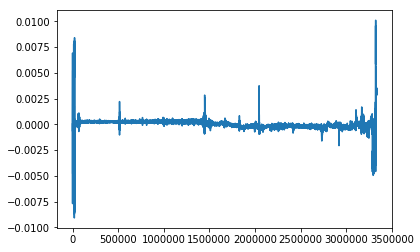

In [48]:
# Plot the data for the first electrode. 
plt.plot(eeg_raw_data[0, :]);

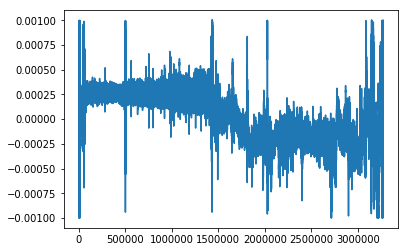

In [49]:
# Plot the data for the first electrode, but only within a certain value range. 
plt.plot(eeg_raw_data[0, np.abs(eeg_raw_data[0, :]) < 0.001]);

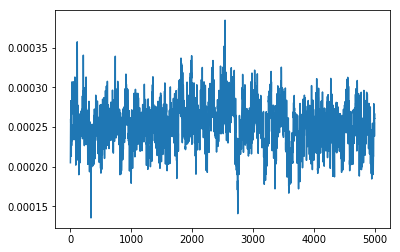

In [50]:
# Plot the data for the first electrode, but only for a selection of 5000 samples. 
plt.plot(eeg_raw_data[0, 100000:105000]);

With these plots we can get an idea of the raw EEG data. It is also possible to **filter the data** according to a certain EEG frequency band, for example the alpha band (8-10 Hz). 

In [51]:
# Filter data in order to obtain the alpha band. 
low_freq, high_freq = 8.0, 10.0 # Values in Hz. 
filtered_object = raw_object.filter(low_freq, high_freq, n_jobs = -1)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 825 samples (1.650 sec)



[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done  69 out of  69 | elapsed:   11.6s finished


In [52]:
# Check the type of the filtered object. 
type(filtered_object)

mne.io.edf.edf.RawEDF

In [53]:
# Export the EEG data into a NumPy array. 
eeg_filtered_data = filtered_object.get_data()
eeg_filtered_data

array([[-8.68208771e-20, -9.15254195e-07, -1.96387827e-06, ...,
         3.42820058e-06,  1.72349862e-06, -4.74338450e-20],
       [ 2.28698896e-20,  6.51771120e-08,  1.47909646e-07, ...,
        -1.12919742e-06, -5.70197477e-07,  1.03761536e-20],
       [ 1.94817578e-20, -1.28067263e-07, -2.39273167e-07, ...,
        -6.89961049e-07, -3.48196156e-07,  1.48230766e-21],
       ...,
       [-2.71050543e-20, -2.05392120e-05, -4.07937435e-05, ...,
        -3.13441285e-05, -1.57744517e-05,  4.82808780e-20],
       [ 8.47032947e-20,  4.46645885e-07,  1.11543706e-06, ...,
        -2.21506191e-07, -1.09955440e-07,  3.17637355e-20],
       [ 4.23516474e-21, -1.04795789e-06, -2.06125793e-06, ...,
         4.76455495e-06,  2.39202118e-06, -4.23516474e-21]])

In [54]:
# Check that this is indeed a NumPy array. 
type(eeg_filtered_data)

numpy.ndarray

In [55]:
# Check the size of the array. 
eeg_filtered_data.shape

(69, 3337000)

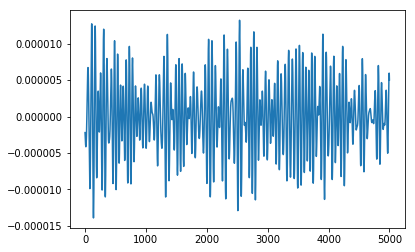

In [56]:
# Plot the data for the first electrode, but only for a selection of 5000 samples. 
plt.plot(eeg_filtered_data[0, 100000:105000]);

We will not explore further the raw EEG data, since the relevant **EEG frequency bands** have already been extracted by the authors of the article. Instead, we will now come back to the TSV file containing both the hypnogram and the power spectrum of these different bands, and have a closer look at the different bands for one subject. 

In [57]:
# Define the path of the hypnogram and power spectrum for this subject. 
hypnogram_path = data_path + 'derivatives/' + subject_index + '_task-rest_hypnogram-powerspectrum.tsv'

# Extract the file as a Pandas DataFrame, and display it. 
hypnogram = pd.read_csv(hypnogram_path, sep = '\t')
hypnogram.head()

,num_scan,hypnogram,SW,delta,theta,alpha,sigma,beta
0,1,0,2.495383,1.645197,1.825207,1.696705,1.498177,-0.265493
1,2,0,2.500000,1.650000,1.830000,1.696705,1.498177,-0.265493
2,3,0,2.500000,1.650000,1.830000,1.700000,1.498177,-0.265493
3,4,0,2.495383,1.650000,1.830000,1.700000,1.498177,-0.265493
4,5,0,2.495383,1.650000,1.825207,1.696705,1.498177,-0.265493


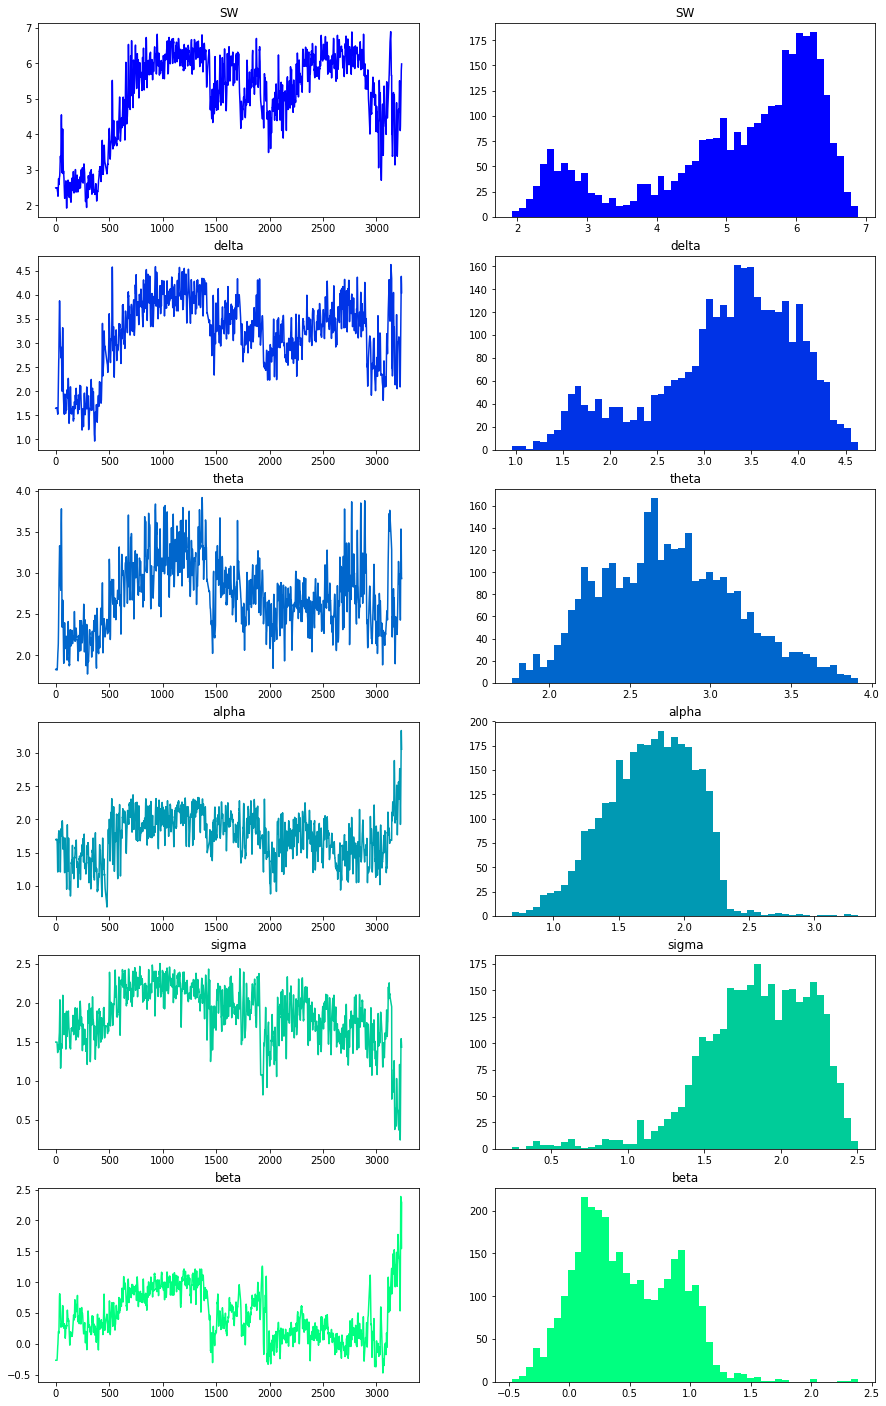

In [58]:
# Display a graph of EEG frequency bands. 
eeg_bands = ['SW', 'delta', 'theta', 'alpha', 'sigma', 'beta']
fig, axes = plt.subplots(nrows = 6, ncols = 2, figsize = (15, 25))
counter = 0

# Iterate through all frequency bands. 
for eeg_band_index in eeg_bands:
    
    # Define colormap and select a color for the frequency band. 
    cm = plt.cm.get_cmap('winter')
    c = cm(0.2 * counter)
    
    # Draw the graphs. 
    axes[counter, 0].plot(hypnogram[eeg_band_index], color = c)
    axes[counter, 0].set_title(eeg_band_index)
    axes[counter, 1].hist(hypnogram[eeg_band_index], bins = 50, color = c)
    axes[counter, 1].set_title(eeg_band_index);
    
    # Increment. 
    counter += 1

We can see that the different frequency bands behave differently during the session, and that their values are also distributed differently. We can also have a look at a specific frequency band, for example the **alpha band**, for all subjects. We will show the graphs individually for each subject, and then for all subjects simultaneously. 

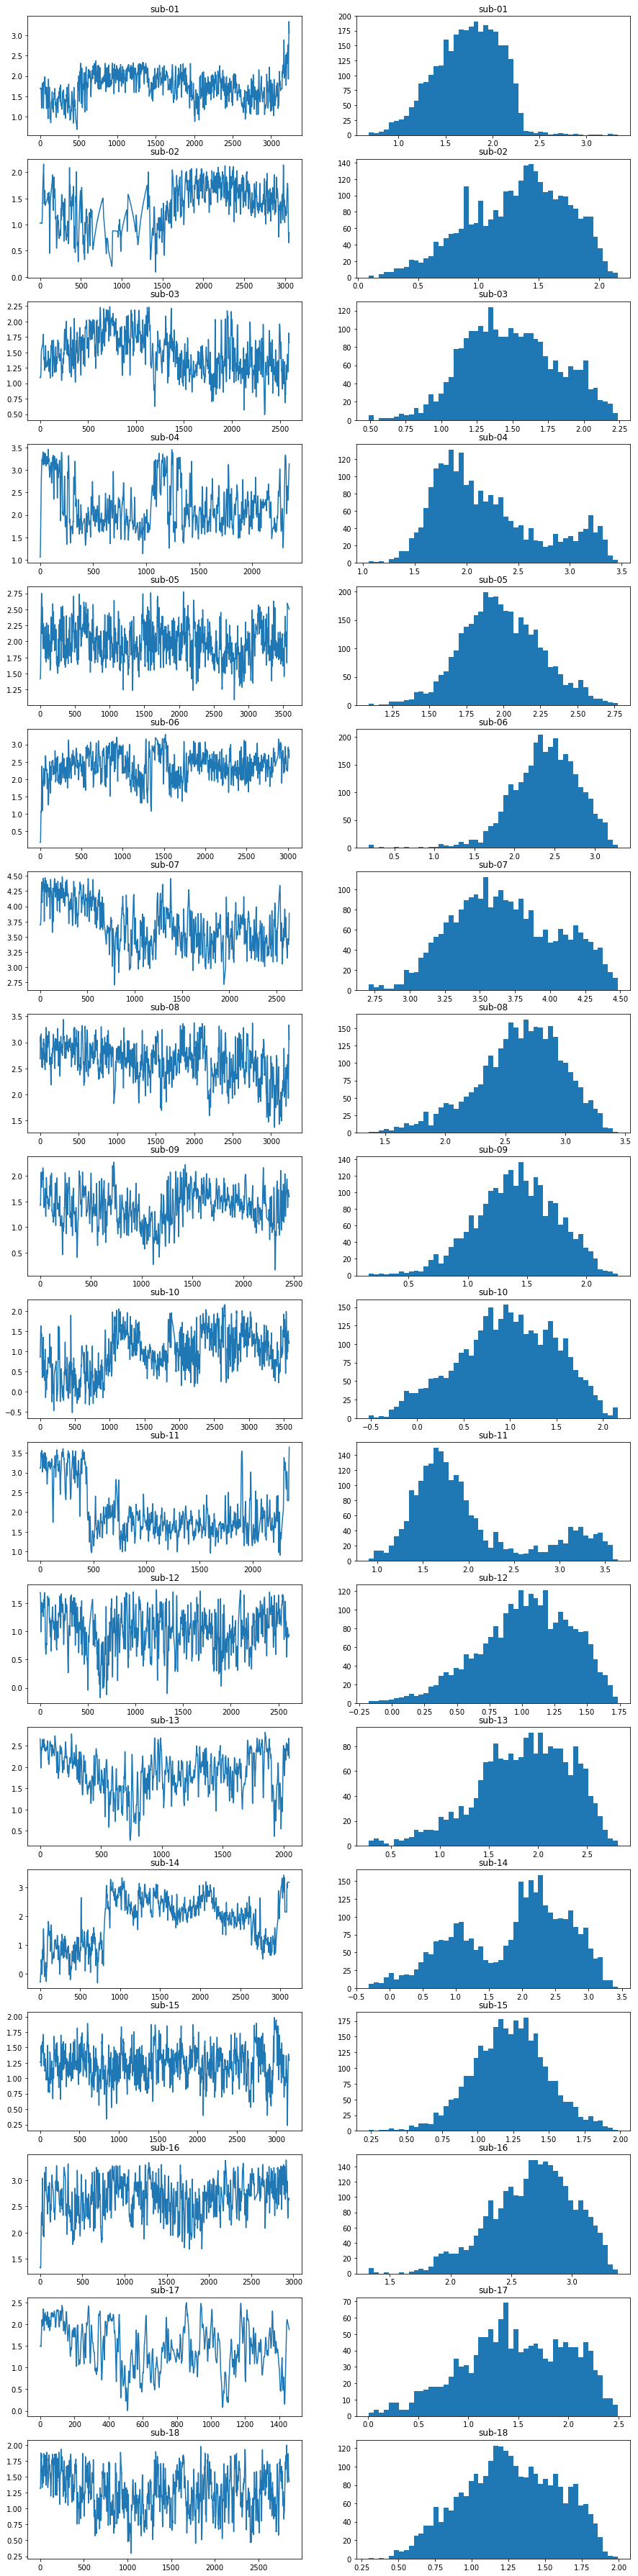

In [59]:
# Display a graph of the alpha frequency band for all subjects. 
fig, axes = plt.subplots(nrows = 18, ncols = 2, figsize = (15, 65))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Define the path of the hypnogram and power spectrum, and extract the file as a Pandas DataFrame. 
    try:
        hypnogram_path = data_path + 'derivatives/' + subject_index + '_task-rest_hypnogram-powerspectrum.tsv'
        hypnogram = pd.read_csv(hypnogram_path, sep = '\t')
    except UnicodeDecodeError:
        hypnogram_path = repaired_files_path + '/' + subject_index + '_task-rest_hypnogram-powerspectrum.tsv'
        hypnogram = pd.read_csv(hypnogram_path, sep = '\t')
    
    # Draw the graphs. 
    axes[counter, 0].plot(hypnogram['alpha'])
    axes[counter, 0].set_title(subject_index)
    axes[counter, 1].hist(hypnogram['alpha'], bins = 50)
    axes[counter, 1].set_title(subject_index);
    
    # Increment. 
    counter += 1

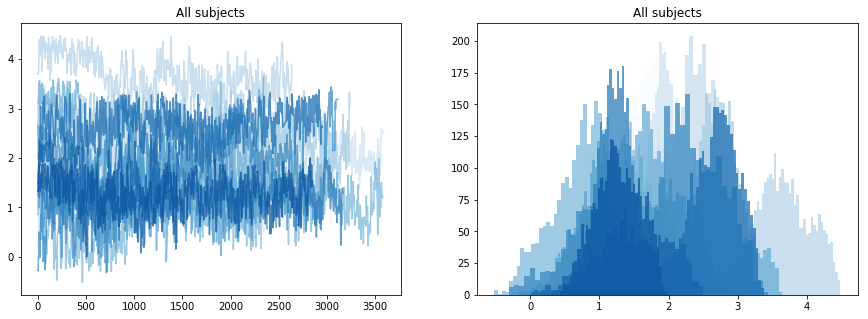

In [60]:
# Display a graph of the alpha frequency band for all subjects. 
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Define colormap and select a color for the subject. 
    cm = plt.cm.get_cmap('Blues')
    c = cm(0.05 * counter)
    
    # Define the path of the hypnogram and power spectrum, and extract the file as a Pandas DataFrame. 
    try:
        hypnogram_path = data_path + 'derivatives/' + subject_index + '_task-rest_hypnogram-powerspectrum.tsv'
        hypnogram = pd.read_csv(hypnogram_path, sep = '\t')
    except UnicodeDecodeError:
        hypnogram_path = repaired_files_path + '/' + subject_index + '_task-rest_hypnogram-powerspectrum.tsv'
        hypnogram = pd.read_csv(hypnogram_path, sep = '\t')
    
    # Draw the graphs. 
    axes[0].plot(hypnogram['alpha'], color = c, alpha = 0.75)
    axes[0].set_title('All subjects')
    axes[1].hist(hypnogram['alpha'], bins = 50, color = c, alpha = 0.75)
    axes[1].set_title('All subjects');
    
    # Increment. 
    counter += 1

We can see that the alpha band behaves differently during the session for the different subjects, and that its values are also distributed differently. As in most neuroimaging studies, we expect a certain level of **inter-subject variability**. In our particular dataset, we have even stronger reasons to suspect that the subjects will show different behaviors. Indeed, the EEG frequency bands are known to differ significatively between the state of wakefulness and the different sleep stages, and these states could not be controlled precisely by the experimental design. Therefore, during the rest session, the different subjects may experience **different successions of wakefulness, light sleep, deep sleep and REM (Rapid Eye Movement) sleep**, and their EEG frequency bands may show very distinct patterns. 

### 4.2 fMRI data analysis

In the following cells, we load the **data from our fMRI dataset**, and perform some exploratory analysis. In particular, we explore the data structure, show some examples of brain images and their value distribution, observe the differences between two images and compare the images from the different subjects. 

In [61]:
# Define an example subject. 
subject_index = subjects[0]

# Load a NIFTI image using the NiBabel library, and display its size. 
img = nib.load(data_path + subject_index + '/func/' +  subject_index + '_task-rest_bold.nii.gz')
img.shape

(64, 64, 36, 3143)

In [62]:
# Extract the image data, and display its size. 
image_data = img.get_fdata()
image_data.shape

(64, 64, 36, 3143)

In [63]:
# Display the number of scans. 
nb_scans = image_data.shape[3]
nb_scans

3143

In [64]:
# Check that the image data is a NumPy array. 
type(image_data) == np.ndarray

True

In [65]:
# Check that the image data is in float64 format. 
image_data.dtype == np.dtype(np.float64)

True

In [66]:
# Display the total number of values for one 3D volume. 
np.prod(image_data[:, :, :, 0].shape)

147456

In [67]:
# Display the memory usage. 
print('Image size:', str(image_data.nbytes), 'bytes')

Image size: 3707633664 bytes


In [68]:
# Display the metadata of the image. 
print(img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 57
dim             : [   4   64   64   36 3143    1    1    1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         3.203125   3.203125   3.8400002  2.1        0.
  0.         0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : sequential decreasing
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'TE=30;Time=215729.790;phase=1'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 5.0051313e-17
quatern_c       : 0.99897057
quatern_d       

The metadata contains mostly information specific to the **fMRI preprocessing**. The attribute 'dim' refers to the data dimensionality, starting with the number of dimensions (4), followed by the lengths of the three first dimensions (64, 64, 36) which are consistent with the size of the NumPy array, and by the fourth dimension which is the number of scans. A complete definition of the NIFTI header can be found here: https://nifti.nimh.nih.gov/pub/dist/src/niftilib/nifti1.h. 

In [69]:
# Define a function to return the middle sections of an image data array. 
def middle_sections(image_data):
    return tuple((np.array(image_data[:, :, :].shape) / 2).astype(int))

In [70]:
# Find the middle sections coordinates of the image data array. 
middle_coord = middle_sections(image_data[:, :, :, 0])
middle_coord

(32, 32, 18)

In [71]:
# Define a function to display sections of an image through the sagittal, coronal and axial views, using the middle sections coordinates. 
def display_fMRI_image(image_data, middle_coord, scan = 0):
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
    axes[0].imshow(image_data[middle_coord[0], :, :, scan].T, origin = 'lower')
    axes[0].set_title('Sagittal view')
    axes[1].imshow(image_data[:, middle_coord[1], :, scan].T, origin = 'lower')
    axes[1].set_title('Coronal view')
    axes[2].imshow(image_data[:, :, middle_coord[2], scan], origin = 'lower')
    axes[2].set_title('Axial view');

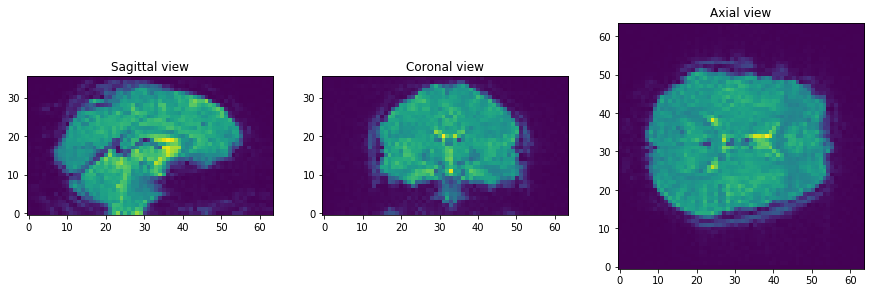

In [72]:
# Display sections of an image through the sagittal, coronal and axial views, using the middle sections coordinates. 
display_fMRI_image(image_data, middle_coord)

In this example image, displayed using the middle section of the sagittal, coronal and axial views, we can see that different brain regions show different activity patterns. We must remember that these are only 2D sections of a larger 3D image, and that each 3D image is just one scan inside a larger 4D array. We can already notice that by construction, **a large part of these values will be irrelevant for our analysis**. Indeed, each scan covers a cubic 3D space, inside which only the central voxels represent the brain of the subject. 

In [73]:
# Display the proportion of NaN values for all the scans. 
np.sum(np.isnan(image_data)) / np.prod(image_data.shape)

0.0

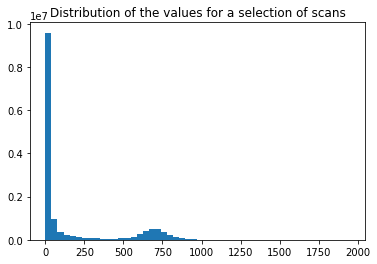

In [74]:
# Select randomly a certain number of scans. 
nb_selected_scans = 100
random_scans = np.random.randint(0, nb_scans, size = nb_selected_scans)

# Display an histogram of the values inside these scans. 
plt.hist(image_data[:, :, :, random_scans].flatten(), bins = 50)
plt.title('Distribution of the values for a selection of scans');

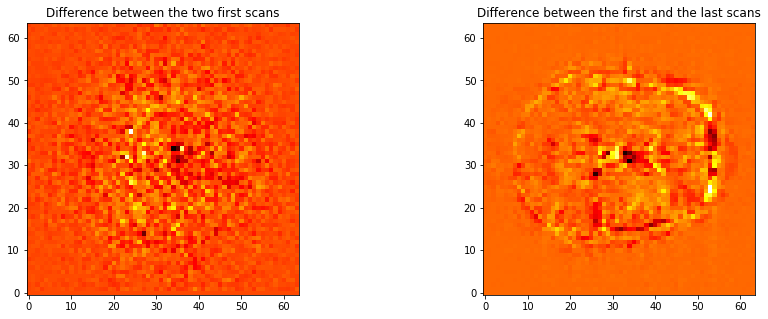

In [75]:
# Display the difference between the two first scans, and between the first and the last scans. 
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
axes[0].imshow(image_data[:, :, middle_coord[2], 0] - image_data[:, :, middle_coord[2], 1], 
           origin = 'lower', cmap = plt.get_cmap('hot'))
axes[0].set_title('Difference between the two first scans')
axes[1].imshow(image_data[:, :, middle_coord[2], 0] - image_data[:, :, middle_coord[2], (nb_scans - 1)], 
           origin = 'lower', cmap = plt.get_cmap('hot'))
axes[1].set_title('Difference between the first and the last scans');

We can see that there are indeed **some differences between the scans**. The differences seem bigger between the first and the last scan than between the two first scans. Now we can look at the brain images for all the subjects. 

Starting subject: sub-01
Starting subject: sub-02
Starting subject: sub-03
Starting subject: sub-04
Starting subject: sub-05
Starting subject: sub-06
Starting subject: sub-07
Starting subject: sub-08
Starting subject: sub-09
Starting subject: sub-10
Starting subject: sub-11
Starting subject: sub-12
Starting subject: sub-13
Starting subject: sub-14
Starting subject: sub-15
Starting subject: sub-16
Starting subject: sub-17
Starting subject: sub-18


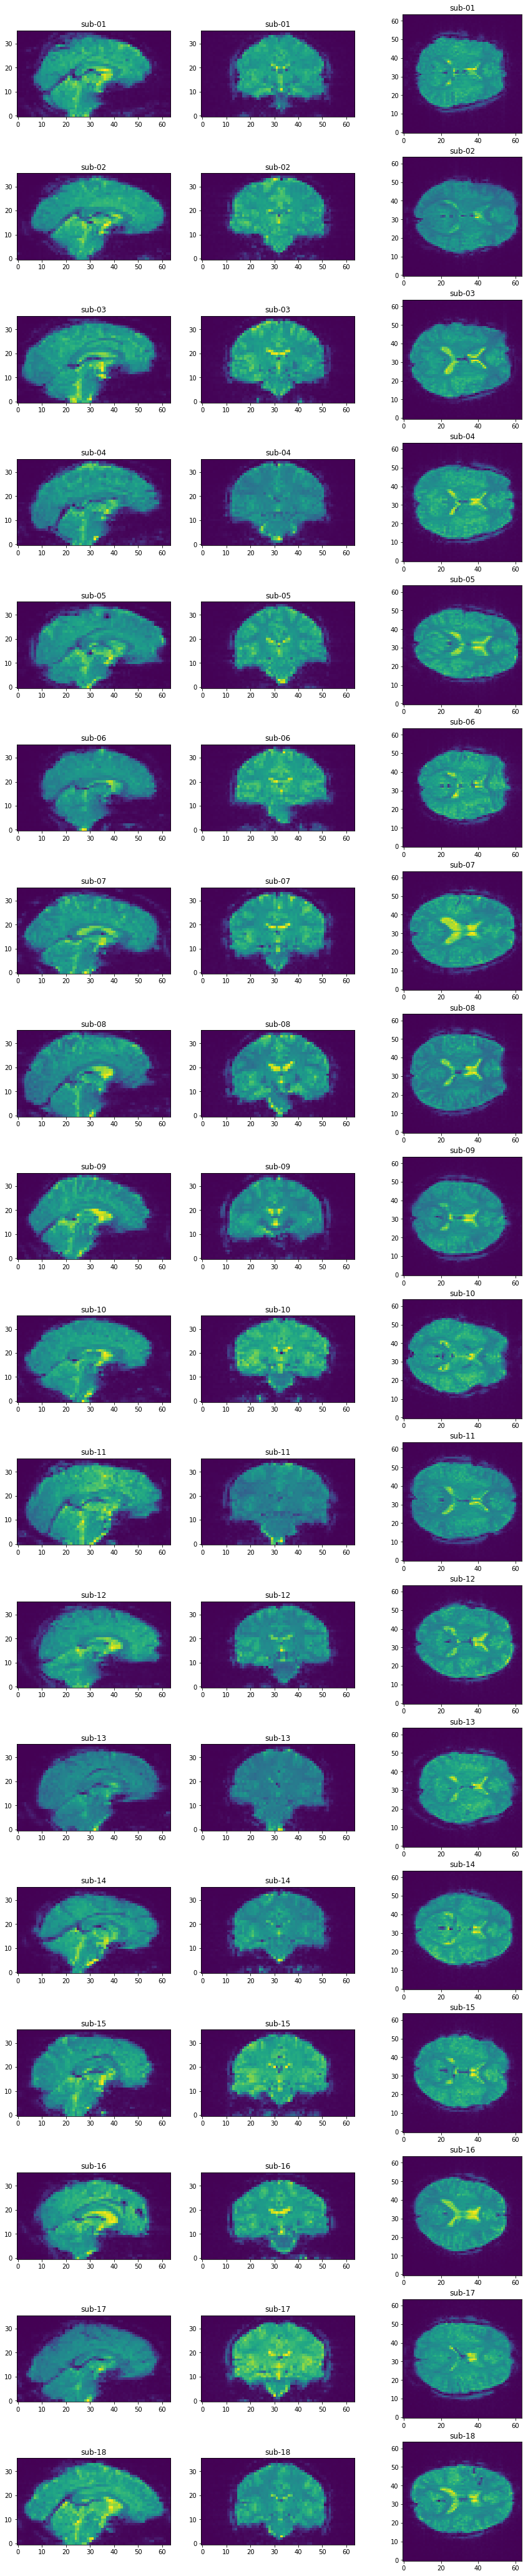

In [76]:
# Compare the 3D images between all subjects. 
fig, axes = plt.subplots(nrows = 18, ncols = 3, figsize = (15, 75))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Display current subject. 
    print('Starting subject: ' + subject_index)
    
    # Load a NIFTI image using the NiBabel library. 
    img = nib.load(data_path + subject_index + '/func/' +  subject_index + '_task-rest_bold.nii.gz')
    
    # Extract the image data. 
    image_data = img.get_fdata()
    
    # Display sections of an image through the sagittal, coronal and axial views, using the middle sections coordinates. 
    axes[counter, 0].imshow(image_data[middle_coord[0], :, :, 0].T, origin = 'lower')
    axes[counter, 0].set_title(subject_index)
    axes[counter, 1].imshow(image_data[:, middle_coord[1], :, 0].T, origin = 'lower')
    axes[counter, 1].set_title(subject_index)
    axes[counter, 2].imshow(image_data[:, :, middle_coord[2], 0], origin = 'lower')
    axes[counter, 2].set_title(subject_index);
    
    # Increment. 
    counter += 1

If we were working with fMRI statistical maps, i.e. the maps obtained at a more advanced step in the fMRI analysis pipeline, the 3D images would not represent the brains of the different subjects in their true proportions, but rather a **normalized version using a standardized brain model, such as the MNI template**. In other words, when we reach this more advanced step, the brain data of every subject is transformed into a standard space, in order to allow meaningful comparisons and statistics. The normalization process is not perfect, but as a corrective measure, the data is typically smoothed with a Gaussian kernel, as it is the case in this study. One key implication of the normalization is that a (xi, yi, zi) voxel from one subject and one condition is comparable to a (xi, yi, zi) voxel of another subject or another condition. In other words, thanks to the normalization, the 3D images can be compared elementwise between several subjects or conditions. 

In contrast, our dataset contains only the BOLD (Blood Oxygen Level Dependent) 3D images, i.e. the raw data before the normalization step. In the images above, we can clearly see that **our brain images are not yet normalized into a common template**. Therefore, in our case, **the elementwise comparison between subjects is not possible**, since the voxel positions are not comparable. This limitation has important implications for our machine learning models. Since the brains in our fMRI dataset exist in different features spaces, **pooling the data from several subjects and running a regression model on the pooled dataset would not be possible without additional normalization steps**, which are outside the scope of this project. This is not a problem for us, since we are primarily interested in predicting EEG activity from fMRI activity and vice versa, and this can be done at the level of a single subject. But this limitation sheds light on the importance of normalization for machine learning projects using fMRI data. 

### 4.3 Relationship between the predictors

In the following cells, we explore the relationship between the **frequency bands from our EEG dataset** and the **BOLD signal from our fMRI dataset**. Since we have no particular brain regions of interest, we will simply compute the mean value of the BOLD signal, and compare it with the values of the frequency bands. 

In [77]:
# Create a dictionary to hold the results. 
relationship_results = dict()

# Iterate through all subjects. 
for subject_index in subjects[1:]: # Warning: the first subject has inconsistent length of EEG and fMRI data. 
    
    # Display current subject. 
    print('Starting subject: ' + subject_index)
    
    # Load a NIFTI image, extract the image data and retrieve the number of scans. 
    img = nib.load(data_path + subject_index + '/func/' +  subject_index + '_task-rest_bold.nii.gz')
    image_data = img.get_fdata()
    nb_scans = image_data.shape[3]
    
    # Define the path of the hypnogram and power spectrum, and extract the file as a Pandas DataFrame. 
    try:
        hypnogram_path = data_path + 'derivatives/' + subject_index + '_task-rest_hypnogram-powerspectrum.tsv'
        hypnogram = pd.read_csv(hypnogram_path, sep = '\t')
    except UnicodeDecodeError:
        hypnogram_path = repaired_files_path + '/' + subject_index + '_task-rest_hypnogram-powerspectrum.tsv'
        hypnogram = pd.read_csv(hypnogram_path, sep = '\t')
    
    # Create en empty NumPy array to store the average value by scan, as well as the hypnogram and EEG frequency bands. 
    relationship_fMRI_average_EEG_bands = np.zeros((nb_scans, 8))
    
    # Iterate through all scans. 
    for scan_index in range(nb_scans):
        
        # Compute the fMRI average and retrieve the hypnogram and EEG frequency bands for this scan. 
        relationship_fMRI_average_EEG_bands[scan_index, 0] = np.mean(image_data[:, :, :, scan_index])
        relationship_fMRI_average_EEG_bands[scan_index, 1:] = hypnogram.iloc[scan_index, 1:]
    
    # Store the results in the dictionary. 
    relationship_results[subject_index] = relationship_fMRI_average_EEG_bands

Starting subject: sub-02
Starting subject: sub-03
Starting subject: sub-04
Starting subject: sub-05
Starting subject: sub-06
Starting subject: sub-07
Starting subject: sub-08
Starting subject: sub-09
Starting subject: sub-10
Starting subject: sub-11
Starting subject: sub-12
Starting subject: sub-13
Starting subject: sub-14
Starting subject: sub-15
Starting subject: sub-16
Starting subject: sub-17
Starting subject: sub-18


In [78]:
# Check the length of the dictionary. 
len(relationship_results)

17

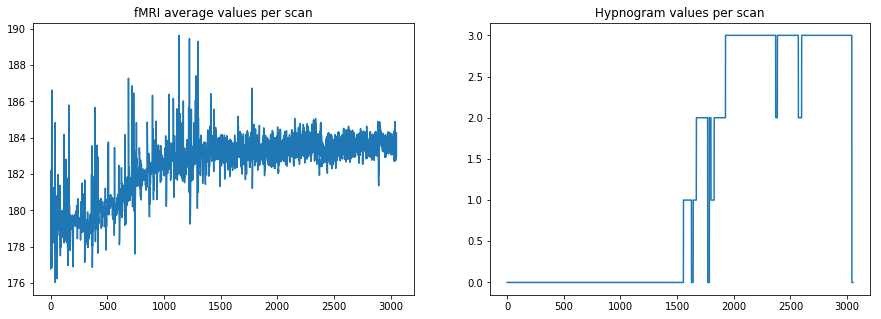

In [79]:
# Define an example subject. 
subject_index = subjects[1] # Warning: the first subject has inconsistent length of EEG and fMRI data. 

# Display the fMRI average values and the hypnogram. 
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
axes[0].plot(relationship_results[subject_index][:, 0])
axes[0].set_title('fMRI average values per scan')
axes[1].plot(relationship_results[subject_index][:, 1])
axes[1].set_title('Hypnogram values per scan');

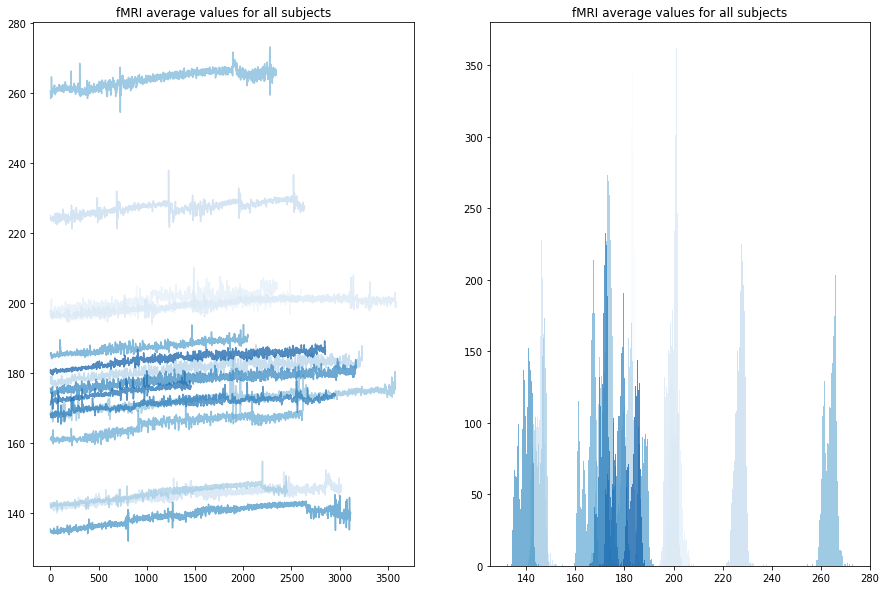

In [80]:
# Display a graph of the fMRI average values for all subjects. 
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 10))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects[1:]:
    
    # Define colormap and select a color for the subject. 
    cm = plt.cm.get_cmap('Blues')
    c = cm(0.05 * counter)
    
    # Draw the graphs. 
    axes[0].plot(relationship_results[subject_index][:, 0], color = c, alpha = 0.75)
    axes[0].set_title('fMRI average values for all subjects')
    axes[1].hist(relationship_results[subject_index][:, 0], bins = 50, color = c, alpha = 0.75)
    axes[1].set_title('fMRI average values for all subjects');
    
    # Increment. 
    counter += 1

We can observe that **the BOLD signal tends to increase during the rest session**, and that **the average value of this signal is different across subjects**. In the neuroimaging literature, we find that an increase of the mean BOLD signal correlated with sleep depth has indeed been noticed (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6827126/), which could provide an explanation for our observation. We can now compute the correlations between the mean BOLD signal and the EEG frequency bands for one subject. 

In [81]:
# Compute the correlations between all variables. 
pd.DataFrame(np.corrcoef(relationship_results[subject_index].T), 
             columns = ['fMRI', 'hypnogram', 'SW', 'delta', 'theta', 'alpha', 'sigma', 'beta'], 
             index = ['fMRI', 'hypnogram', 'SW', 'delta', 'theta', 'alpha', 'sigma', 'beta'])

,fMRI,hypnogram,SW,delta,theta,alpha,sigma,beta
fMRI,1.000000,0.464112,0.341514,0.335367,0.203819,-0.097160,0.242252,-0.161508
hypnogram,0.464112,1.000000,0.213400,0.302050,0.280977,-0.064130,0.276445,-0.216464
SW,0.341514,0.213400,1.000000,0.514955,0.356012,0.131954,0.200661,0.078318
delta,0.335367,0.302050,0.514955,1.000000,0.736245,0.336161,0.521144,0.318536
theta,0.203819,0.280977,0.356012,0.736245,1.000000,0.502891,0.668791,0.422156
alpha,-0.097160,-0.064130,0.131954,0.336161,0.502891,1.000000,0.547339,0.681546
sigma,0.242252,0.276445,0.200661,0.521144,0.668791,0.547339,1.000000,0.519505
beta,-0.161508,-0.216464,0.078318,0.318536,0.422156,0.681546,0.519505,1.000000


In [82]:
import seaborn as sns

/Users/maeldonoso/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


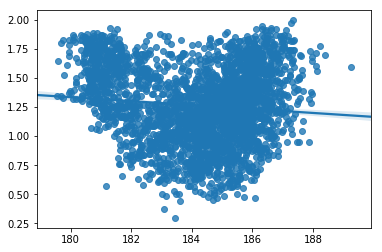

In [83]:
# Display a scatter plot of the fMRI average values and the alpha band, with a regression line. 
sns.regplot(relationship_results[subject_index][:, 0], relationship_results[subject_index][:, 5]);

There is a **certain degree of correlation between the mean BOLD signal and the EEG frequency bands**, and this correlation seems different for the different frequency bands. We can now compute these correlations for all the subjects, and average the values obtained across subjects for each of these bands. 

In [84]:
# Create a NumPy array to store the correlations between the fMRI average values and all the EEG frequency bands, for all subjects. 
correlation_results = np.zeros((len(relationship_results), 6))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects[1:]: # Warning: the first subject has inconsistent length of EEG and fMRI data. 
    
    # Compute the correlations between all variables. 
    correlation_array = np.corrcoef(relationship_results[subject_index].T)
    correlation_results[counter, :] = correlation_array[0, 2:]
    
    # Increment. 
    counter += 1
    
# Store the results in a Pandas DataFrame. 
correlation_results_df = pd.DataFrame(correlation_results, 
                                      columns = ['SW', 'delta', 'theta', 'alpha', 'sigma', 'beta'], 
                                      index = subjects[1:])
# Display the DataFrame. 
correlation_results_df

,SW,delta,theta,alpha,sigma,beta
sub-02,0.343493,0.364924,0.328636,0.286220,0.517747,0.163733
sub-03,-0.014609,-0.025186,-0.151923,-0.256761,-0.034085,0.001457
sub-04,0.185677,0.011857,0.261341,-0.079116,-0.116517,-0.058238
sub-05,0.652093,0.596492,0.491901,-0.098727,0.297960,0.150187
sub-06,0.639408,0.677579,0.796012,0.187113,0.392540,-0.409563
sub-07,0.633637,0.178494,-0.567478,-0.557471,-0.341199,-0.432764
sub-08,0.520394,0.242414,0.145770,-0.218977,0.051524,0.480548
sub-09,0.677874,0.607784,0.479754,0.053853,0.583678,-0.077117
sub-10,0.599841,0.421470,0.167020,0.474958,0.443128,-0.241631
sub-11,0.603255,0.571577,0.398057,-0.502870,0.096644,-0.613451


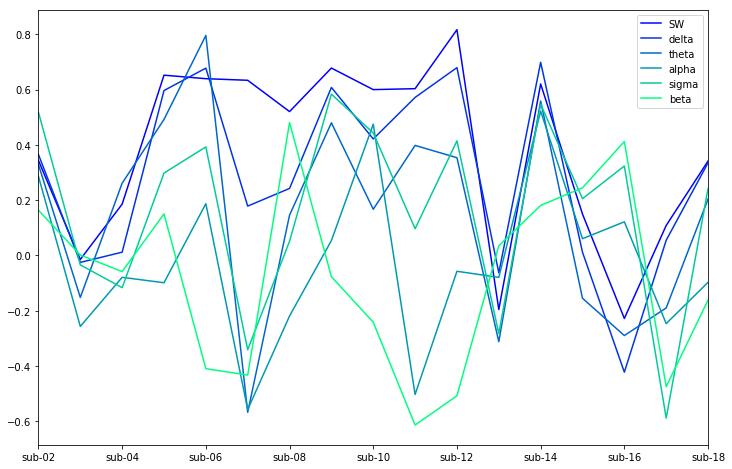

In [85]:
# Display the correlation coefficients in a plot. 
correlation_results_df.plot(figsize = (12, 8), cmap = 'winter');

In [86]:
# Compute the sum of the correlation coefficients per frequency band. 
correlation_results_df.sum()

SW       6.453965
delta    4.942492
theta    2.518657
alpha   -0.487981
sigma    2.752685
beta    -1.308096
dtype: float64

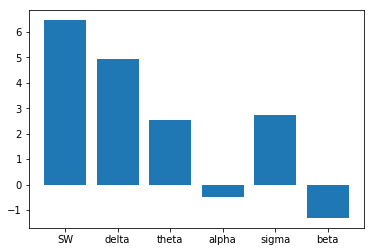

In [87]:
# Display the sum of the correlation coefficients per frequency band. 
plt.bar(range(1, 7), correlation_results_df.sum(), tick_label = correlation_results_df.columns);

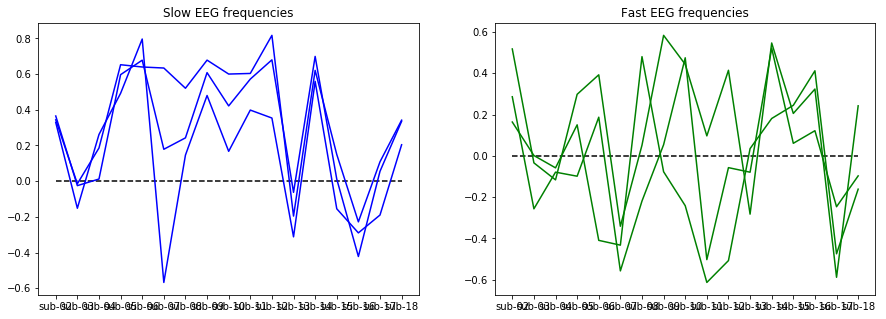

In [88]:
# Display the correlation coefficients for the slow and fast frequencies separately. 
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
axes[0].plot(correlation_results_df.loc[:, ['SW', 'delta', 'theta']], color = 'blue')
axes[0].hlines(0, 0, 16, linestyles = 'dashed')
axes[0].set_title('Slow EEG frequencies')
axes[1].plot(correlation_results_df.loc[:, ['alpha', 'sigma', 'beta']], color = 'green')
axes[1].hlines(0, 0, 16, linestyles = 'dashed')
axes[1].set_title('Fast EEG frequencies');

Overall, there seem to be a **positive correlation between the mean BOLD signal and the slow EEG frequencies** (< 8 Hz: SW, delta, theta), and a **more uncertain correlation pattern between the mean BOLD signal and the fast EEG frequencies** (>= 8 Hz: alpha, sigma, beta), with visible differences between subjects. Of course, the mean BOLD signal is a very rough measure of the brain activity. Our machine learning models will use the fMRI dataset in its true form, i.e. the BOLD signal measured voxel by voxel. Still, we can see that even this first step suggests some patterns of correlation between EEG and fMRI data. 

## **5. Data preprocessing**

### 5.1 Data cleaning

In the following cells, we remove from every subject of our fMRI dataset the **voxels that are not relevant for our analysis**, i.e. the voxels outside the brain. In order to determine roughly the position of these voxels, we examine the distribution of the BOLD signal values, and choose a threshold under which we will transform the values to NaN. In neuroimaging studies, more sophisticated methods are used to distinguish the voxels that are located inside the brain from those that lie outside. Since our brain maps have not been normalized, each subject will be treated individually, and the **voxels that will be removed may vary across subjects**. Nevertheless, we want the features space to be coherent inside a single subject data, therefore we will make sure that the **voxels that will be removed are the same for every scan of a particular subject**. We will attain this objective by using binary masks. 

In [89]:
# Define an example subject. 
subject_index = subjects[0]

# Load a NIFTI image using the NiBabel library, and display its size. 
img = nib.load(data_path + subject_index + '/func/' +  subject_index + '_task-rest_bold.nii.gz')
img.shape

(64, 64, 36, 3143)

In [90]:
# Extract the image data, and display its size. 
image_data = img.get_fdata()
image_data.shape

(64, 64, 36, 3143)

In [91]:
# Display the number of scans. 
nb_scans = image_data.shape[3]
nb_scans

3143

In [92]:
# Compute the sum of all the scans, and display the size of the new array. 
sum_image_data = np.sum(image_data, axis = 3)
sum_image_data.shape

(64, 64, 36)

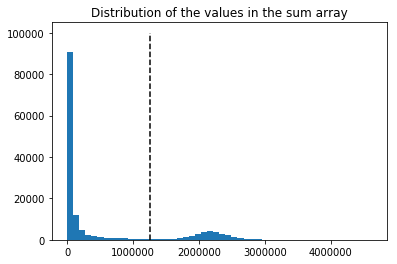

In [93]:
# Define a percentile under which the values will be transformed to NaN. 
percentile_threshold = 80

# Compute the value associated with this percentile. 
nan_threshold = np.percentile(sum_image_data.flatten(), percentile_threshold)

# Display an histogram of the values of the sum array. 
plt.hist(sum_image_data.flatten(), bins = 50)
plt.vlines(nan_threshold, 0, 1e5, linestyles = 'dashed')
plt.title('Distribution of the values in the sum array');

Here we show the **threshold** that will distinguish the voxel values that we will keep from those that we will transform to NaN. Applied on the sum image consisting on the average of all scans, this threshold will allow us to determine the positions of the relevant voxels, i.e. the ones that we will keep, and to store them in a binary mask. 

In [94]:
# Compute a 3D binary mask. 
binary_mask_3d = sum_image_data > nan_threshold
binary_mask_3d.shape

(64, 64, 36)

Now in order to apply the mask to all scans, the cleanest way seems to be a transformation of the 3D binary mask into a 4D binary mask, where the Boolean values are repeated along a 4th dimension. 

In [95]:
# Convert it to a 4D binary mask, by repeating the Boolean values along a 4th dimension. 
binary_mask_4d = np.repeat(binary_mask_3d[:, :, :, np.newaxis], nb_scans, axis = 3)
binary_mask_4d.shape

(64, 64, 36, 3143)

In [96]:
# Check that the 4D binary mask consists, as intended, of a repetition of the 3D binary mask along the 4th dimension. 
mask_repeated_per_scan = []
for scan_index in range(nb_scans):
    mask_repeated_per_scan.append(np.array_equal(binary_mask_4d[:, :, :, scan_index], binary_mask_3d))
np.unique(np.array(mask_repeated_per_scan))

array([ True])

In [97]:
# Check the proportion of True values in the 4D binary mask. 
np.sum(binary_mask_4d) / np.prod(binary_mask_4d.shape)

0.19999864366319445

In [98]:
# Compare this proportion with the proportion predicted from the threshold. 
(100 - percentile_threshold) / 100

0.2

The 4D binary mask seems to be constructed as intended. Depending on the percentile chosen, the proportion of True values in the 4D binary mask may be slightly different from the one predicted from the threshold, but should be very close. Now we can use it to select the relevant values in the brain image. 

In [99]:
# Transform values to NaN according to the binary mask. 
image_data_with_nan = image_data.copy()
image_data_with_nan[~binary_mask_4d] = np.nan
image_data_with_nan.shape

(64, 64, 36, 3143)

In [100]:
# Check the proportion of NaN values in the modified array. 
np.sum(np.isnan(image_data_with_nan)) / np.prod(image_data_with_nan.shape)

0.8000013563368056

In [101]:
# Check that the proportion of NaN values is constant for the different scans. 
nan_per_scan = []
for scan_index in range(nb_scans):
    nan_per_scan.append(np.sum(np.isnan(image_data_with_nan[:, :, :, scan_index])) /
                        np.prod(image_data_with_nan[:, :, :, scan_index].shape))

# Display the unique number of proportion of NaN values. 
np.unique(np.array(nan_per_scan))

array([0.80000136])

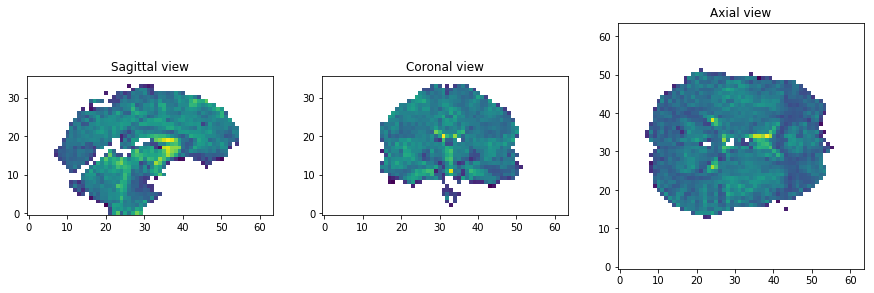

In [102]:
# Display sections of an image through the sagittal, coronal and axial views, using the middle sections coordinates. 
display_fMRI_image(image_data_with_nan, middle_coord)

The preprocessed image seems fine for this subject: the **brain regions are mostly preserved**, while the **volumes outside the brain are transformed to NaN**. Since the brain maps in our fMRI dataset are not normalized, it makes sense to have a look at the preprocessed images for all our subjects, and see if the threshold we have chosen still gives accurate results. We will take advantage of this step to store directly all the preprocessed images in a dictionary, in order to use them for our machine learning models if they seem acceptable. 

Starting subject: sub-01
Starting subject: sub-02
Starting subject: sub-03
Starting subject: sub-04
Starting subject: sub-05
Starting subject: sub-06
Starting subject: sub-07
Starting subject: sub-08
Starting subject: sub-09
Starting subject: sub-10
Starting subject: sub-11
Starting subject: sub-12
Starting subject: sub-13
Starting subject: sub-14
Starting subject: sub-15
Starting subject: sub-16
Starting subject: sub-17
Starting subject: sub-18


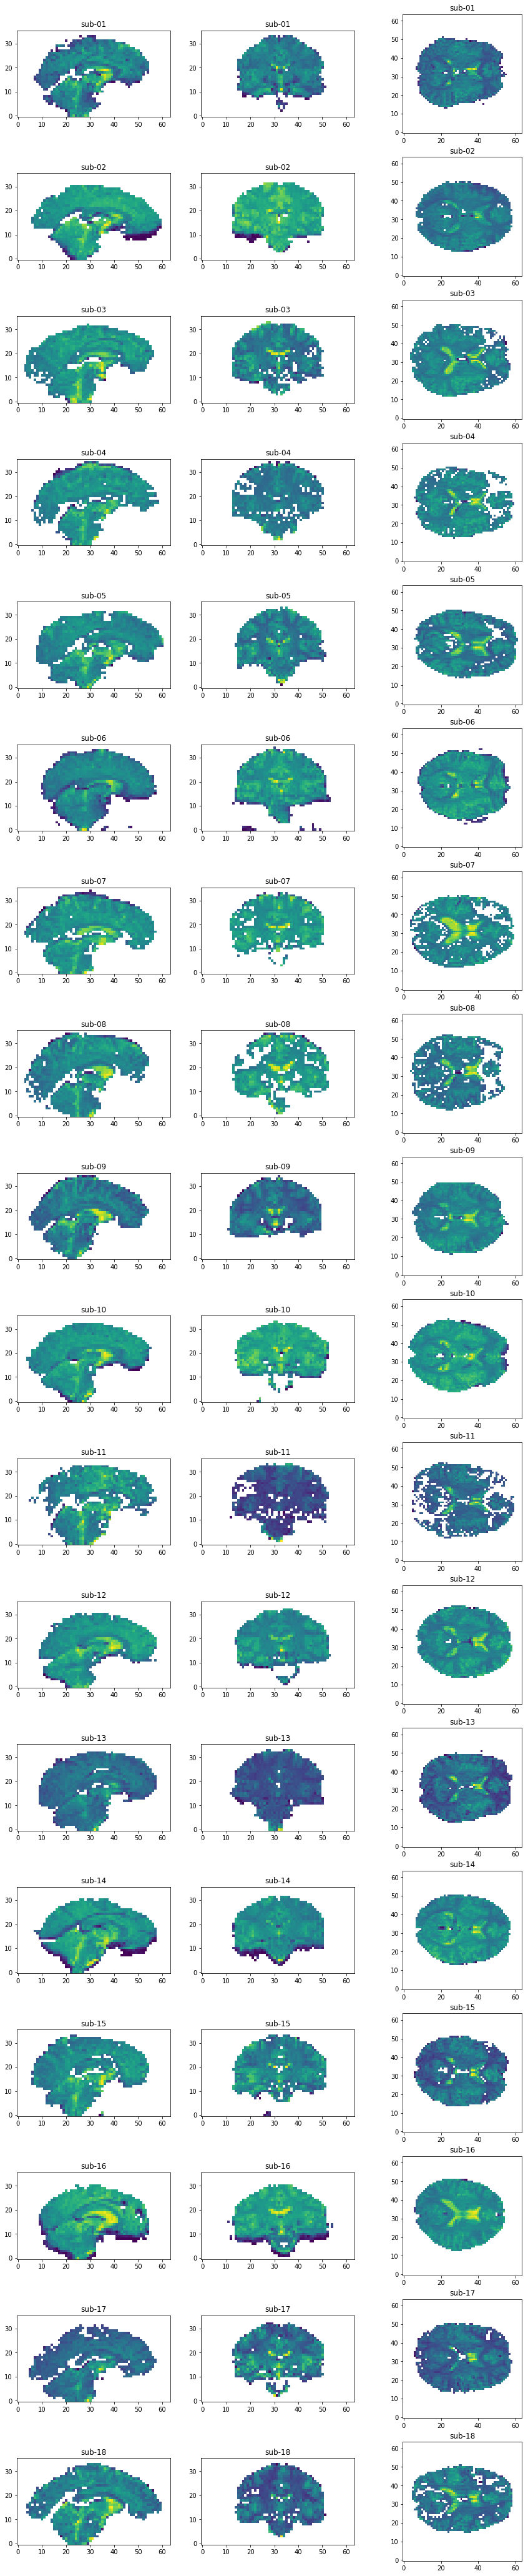

In [103]:
# Define a percentile under which the values will be transformed to NaN. 
percentile_threshold = 80

# Create a dictionary to hold the results. 
predictors_fMRI = dict()

# Compare the 3D images between all subjects. 
fig, axes = plt.subplots(nrows = 18, ncols = 3, figsize = (15, 75))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Display current subject. 
    print('Starting subject: ' + subject_index)
    
    # Load a NIFTI image, extract the image data and retrieve the number of scans. 
    img = nib.load(data_path + subject_index + '/func/' +  subject_index + '_task-rest_bold.nii.gz')
    image_data = img.get_fdata()
    nb_scans = image_data.shape[3]
    
    # Compute the sum of all the scans, and the value associated with the chosen percentile. 
    sum_image_data = np.sum(image_data, axis = 3)
    nan_threshold = np.percentile(sum_image_data.flatten(), percentile_threshold)
    
    # Compute a 3D binary mask, and convert it to a 4D binary mask by repeating the Boolean values along a 4th dimension. 
    binary_mask_3d = sum_image_data > nan_threshold
    binary_mask_4d = np.repeat(binary_mask_3d[:, :, :, np.newaxis], nb_scans, axis = 3)
    
    # Transform values to NaN according to the binary mask. 
    image_data_with_nan = image_data.copy()
    image_data_with_nan[~binary_mask_4d] = np.nan
    
    # Store the results in the dictionary. 
    predictors_fMRI[subject_index] = image_data_with_nan
    
    # Display sections of an image through the sagittal, coronal and axial views, using the middle sections coordinates. 
    axes[counter, 0].imshow(image_data_with_nan[middle_coord[0], :, :, 0].T, origin = 'lower')
    axes[counter, 0].set_title(subject_index)
    axes[counter, 1].imshow(image_data_with_nan[:, middle_coord[1], :, 0].T, origin = 'lower')
    axes[counter, 1].set_title(subject_index)
    axes[counter, 2].imshow(image_data_with_nan[:, :, middle_coord[2], 0], origin = 'lower')
    axes[counter, 2].set_title(subject_index);
    
    # Increment. 
    counter += 1

As we can see, the threshold we have chosen produces results of **variable quality**. In some subjects, parts of the brain are transformed to NaN, while in others, some volumes outside the brain manage to stand above the threshold. Since we will run our machine learning models at a single-subject level, in theory there is no need to apply an identical preprocessing across all subjects. For example, we could use a different threshold for each subject, but this would be very time-consuming, and establishing adequate quality criteria would be a challenge. Instead, we will assume that these preprocessed images are good enough for our purposes. Again, this difficulty could have been avoided if the dataset had contained the brain images normalized on the MNI template, and not just the raw fMRI data. 

### 5.2 Voxel size rescaling

**The high number of voxel values (64 x 64 x 36 x 3143 = 463,454,208 values per 4D array) is certainly one of the key challenges for the use of machine learning models on the fMRI data.** Even for a single scan, the number of voxel values remains quite high (64 x 64 x 36 = 147,456 values per 3D image). One way to address this problem is to reduce the size of the arrays by averaging, on the 3D images, several contiguous voxels into higher-level clusters. In the function below, we use the NumPy function 'mean', therefore the clusters containing at least one NaN voxel will be entirely considered as NaN, which is the most conservative way to manage missing values during rescaling. 

In [104]:
# Define the rescaling function. 
def rescale_image_by_factor(image_data, factor):
    # Get the dimensions of the image data, and create a new, rescaled, image data array. 
    dimensions = np.append((np.array(image_data.shape[0:3]) / factor).astype('int'), image_data.shape[3])
    new_image_data = np.zeros((dimensions))
    
    # Loop over all voxels in the new image data. 
    for x_coord in range(0, dimensions[0]):
        for y_coord in range(0, dimensions[1]):
            for z_coord in range(0, dimensions[2]):
                new_image_data[x_coord, y_coord, z_coord, :] = np.mean(image_data[(factor * x_coord):(factor * x_coord + factor),
                                                                                  (factor * y_coord):(factor * y_coord + factor),
                                                                                  (factor * z_coord):(factor * z_coord + factor),
                                                                                  :], axis = (0, 1, 2))
                
    # Return the new image data and its dimensions. 
    return new_image_data, new_image_data.shape

#### Original voxel size

In [105]:
# Define an example subject. 
subject_index = subjects[0]

# Load a preprocessed image from our dictionary. 
image_data = predictors_fMRI[subject_index]
image_data.shape

(64, 64, 36, 3143)

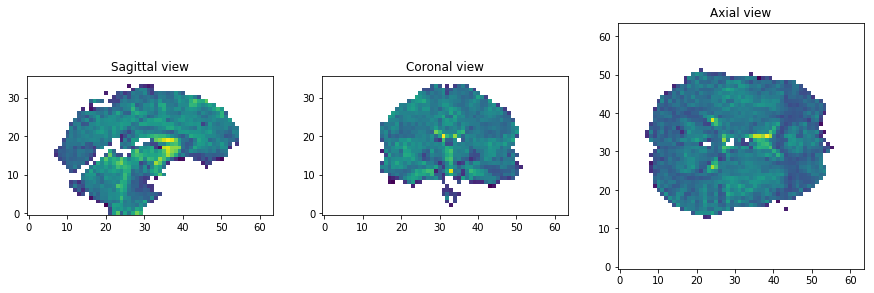

In [106]:
# Display sections of an image through the sagittal, coronal and axial views, using the middle sections coordinates. 
display_fMRI_image(image_data, middle_coord)

#### Voxel size rescaling by a factor 2

In [107]:
# Rescale the voxel size by a factor 2. 
image_data_r2, image_dimensions_r2 = rescale_image_by_factor(image_data, 2)
image_dimensions_r2

(32, 32, 18, 3143)

In [108]:
# Find the middle coordinates for the rescaled image. 
middle_coord_r2 = middle_sections(image_data_r2)
middle_coord_r2

(16, 16, 9, 1571)

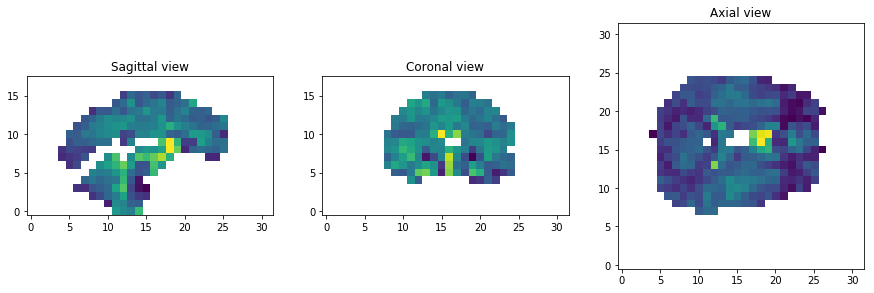

In [109]:
# Display sections of an image through the sagittal, coronal and axial views, using the middle sections coordinates. 
display_fMRI_image(image_data_r2, middle_coord_r2)

In [110]:
# Display the memory usage. 
print('Original image:', str(image_data.nbytes), 'bytes')
print('Rescaled image:', str(image_data_r2.nbytes), 'bytes')
print('The original image is', str(np.round(image_data.nbytes / image_data_r2.nbytes, 2)), 'times heavier than the rescaled image.')

Original image: 3707633664 bytes
Rescaled image: 463454208 bytes
The original image is 8.0 times heavier than the rescaled image.


#### Voxel size rescaling by a factor 3

In [111]:
# Rescale the voxel size by a factor 3. 
image_data_r3, image_dimensions_r3 = rescale_image_by_factor(image_data, 3)
image_dimensions_r3

(21, 21, 12, 3143)

In [112]:
# Find the middle coordinates for the rescaled image. 
middle_coord_r3 = middle_sections(image_data_r3)
middle_coord_r3

(10, 10, 6, 1571)

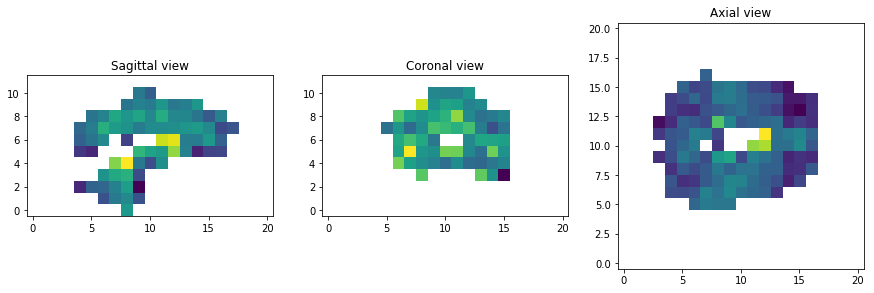

In [113]:
# Display sections of an image through the sagittal, coronal and axial views, using the middle sections coordinates. 
display_fMRI_image(image_data_r3, middle_coord_r3)

In [114]:
# Display the memory usage. 
print('Original image:', str(image_data.nbytes), 'bytes')
print('Rescaled image:', str(image_data_r3.nbytes), 'bytes')
print('The original image is', str(np.round(image_data.nbytes / image_data_r3.nbytes, 2)), 'times heavier than the rescaled image.')

Original image: 3707633664 bytes
Rescaled image: 133062048 bytes
The original image is 27.86 times heavier than the rescaled image.


As expected, we see that the rescaled brain images show a rougher distribution of the same patterns. Also as expected, the memory gain factor is about 8 (2 x 2 x 2) for the rescaling by a factor 2, and about 27 (3 x 3 x 3) for the rescaling by a factor 3. We can now run the voxel size rescaling process for all our subjects, and store all the rescaled images in dictionaries. 

In [115]:
# Create dictionaries to hold the results. 
predictors_fMRI_r2 = dict()
predictors_fMRI_r3 = dict()

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Display current subject. 
    print('Starting subject: ' + subject_index)
    
    # Load the preprocessed image with the original voxel size. 
    image_data = predictors_fMRI[subject_index]
    
    # Rescale the voxel size by a factor 2, and store the result in the appropriate dictionary. 
    image_data_r2, _ = rescale_image_by_factor(image_data, 2)
    predictors_fMRI_r2[subject_index] = image_data_r2
    
    # Rescale the voxel size by a factor 3, and store the result in the appropriate dictionary. 
    image_data_r3, _ = rescale_image_by_factor(image_data, 3)
    predictors_fMRI_r3[subject_index] = image_data_r3

Starting subject: sub-01
Starting subject: sub-02
Starting subject: sub-03
Starting subject: sub-04
Starting subject: sub-05
Starting subject: sub-06
Starting subject: sub-07
Starting subject: sub-08
Starting subject: sub-09
Starting subject: sub-10
Starting subject: sub-11
Starting subject: sub-12
Starting subject: sub-13
Starting subject: sub-14
Starting subject: sub-15
Starting subject: sub-16
Starting subject: sub-17
Starting subject: sub-18


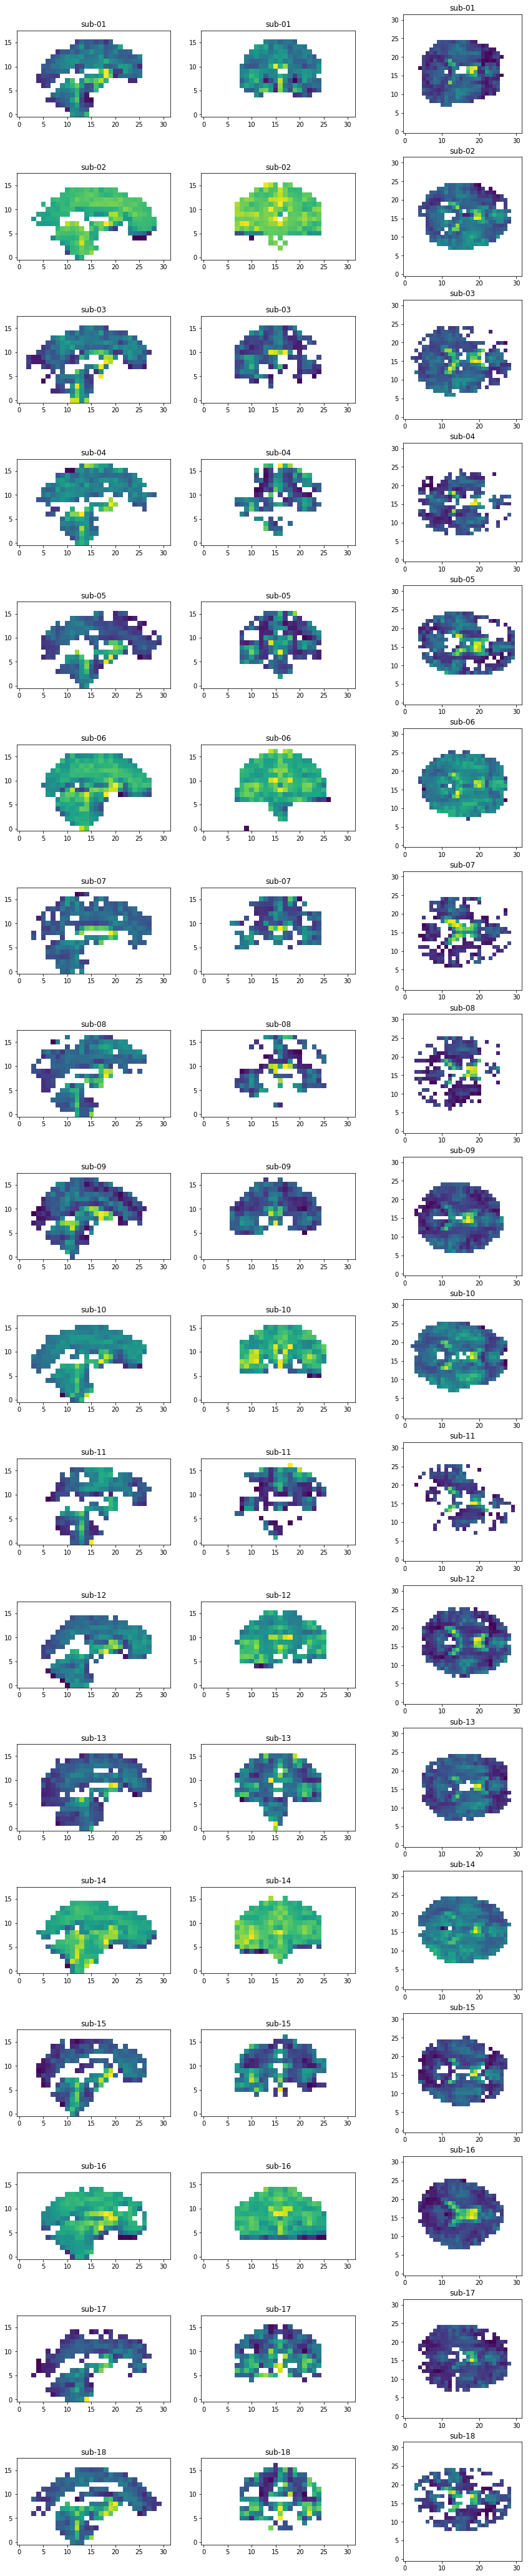

In [116]:
# Compare the images rescaled by a factor 2 between all subjects. 
fig, axes = plt.subplots(nrows = 18, ncols = 3, figsize = (15, 75))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Load the rescaled image. 
    rescaled_image_data = predictors_fMRI_r2[subject_index]
    
    # Display sections of an image through the sagittal, coronal and axial views, using the middle sections coordinates. 
    axes[counter, 0].imshow(rescaled_image_data[middle_coord_r2[0], :, :, 0].T, origin = 'lower')
    axes[counter, 0].set_title(subject_index)
    axes[counter, 1].imshow(rescaled_image_data[:, middle_coord_r2[1], :, 0].T, origin = 'lower')
    axes[counter, 1].set_title(subject_index)
    axes[counter, 2].imshow(rescaled_image_data[:, :, middle_coord_r2[2], 0], origin = 'lower')
    axes[counter, 2].set_title(subject_index);
    
    # Increment. 
    counter += 1

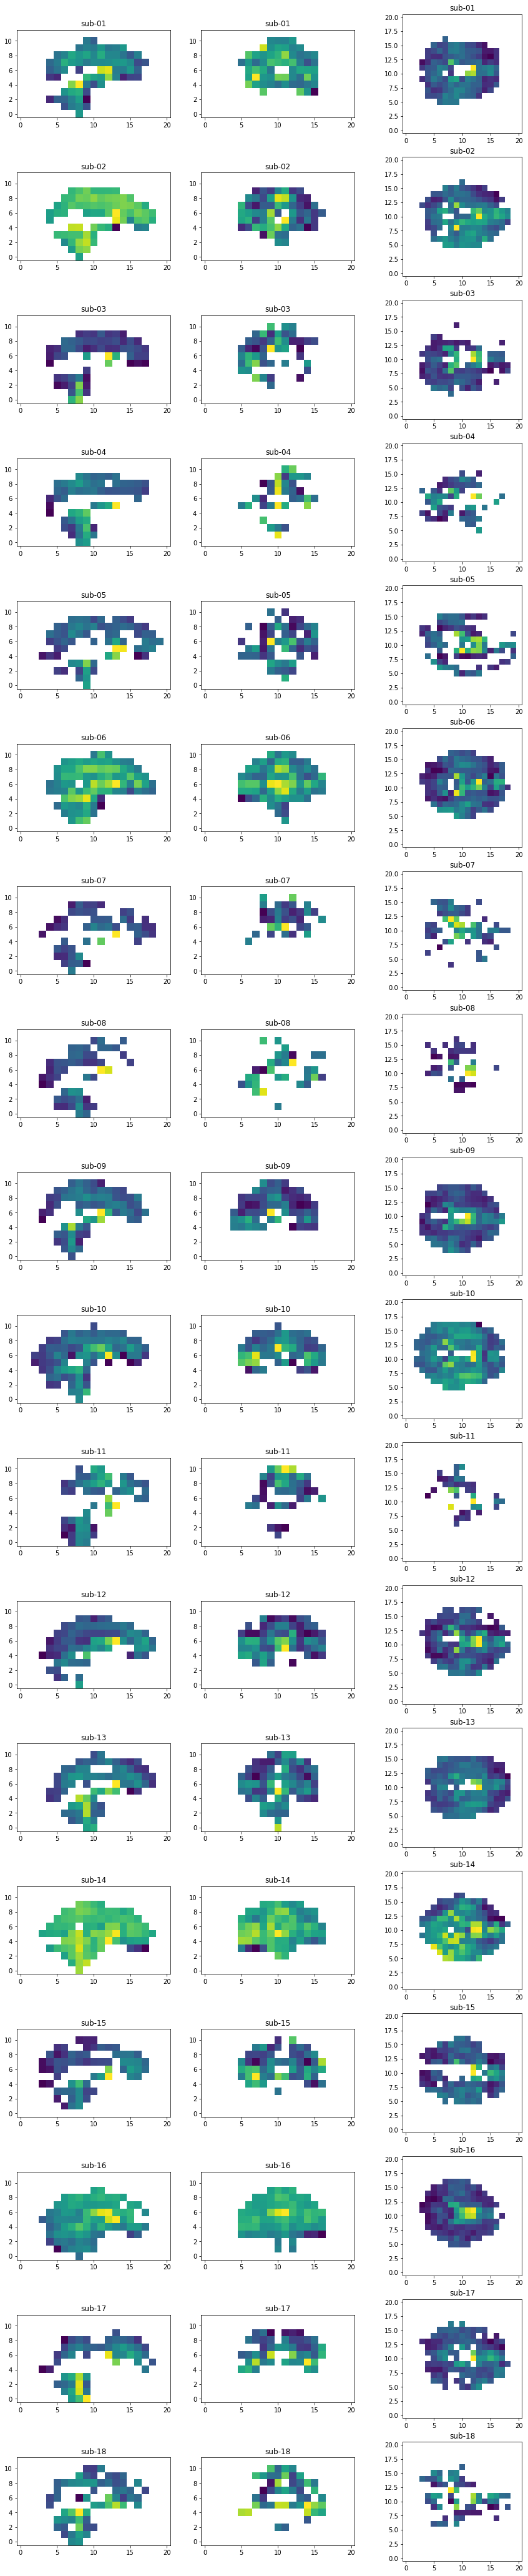

In [117]:
# Compare the images rescaled by a factor 3 between all subjects. 
fig, axes = plt.subplots(nrows = 18, ncols = 3, figsize = (15, 75))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Load the rescaled image. 
    rescaled_image_data = predictors_fMRI_r3[subject_index]
    
    # Display sections of an image through the sagittal, coronal and axial views, using the middle sections coordinates. 
    axes[counter, 0].imshow(rescaled_image_data[middle_coord_r3[0], :, :, 0].T, origin = 'lower')
    axes[counter, 0].set_title(subject_index)
    axes[counter, 1].imshow(rescaled_image_data[:, middle_coord_r3[1], :, 0].T, origin = 'lower')
    axes[counter, 1].set_title(subject_index)
    axes[counter, 2].imshow(rescaled_image_data[:, :, middle_coord_r3[2], 0], origin = 'lower')
    axes[counter, 2].set_title(subject_index);
    
    # Increment. 
    counter += 1

Since we managed missing values in the most conservative way, by considering as NaN all clusters that contain at least one NaN voxel, some brain images seem now really torn up. Again, this difficulty could have been largely avoided if the dataset had contained the brain images normalized on the MNI template, since in this case, the volumes outside the brain would have been much easier to exclude, and our brain data would have been much more homogeneous. As a security check, we will compute and display the **remaining number of non-NaN values** in our rescaled images. 

In [118]:
# Create a Pandas DataFrame. 
non_nan_proportions = pd.DataFrame(columns = ['original voxel size', 'factor 2', 'factor 3'])

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Load the image with the original voxel size, compute the proportion of non-NaN values and fill in the DataFrame. 
    original_image_data = predictors_fMRI[subject_index]
    non_nan_proportions.loc[subject_index, 'original voxel size'] = 1 - np.isnan(original_image_data).sum() / np.prod(original_image_data.shape)
    
    # Load the rescaled image by a factor 2, compute the proportion of non-NaN values and fill in the DataFrame. 
    rescaled_image_data = predictors_fMRI_r2[subject_index]
    non_nan_proportions.loc[subject_index, 'factor 2'] = 1 - np.isnan(rescaled_image_data).sum() / np.prod(rescaled_image_data.shape)
    
    # Load the rescaled image by a factor 3, compute the proportion of non-NaN values and fill in the DataFrame. 
    rescaled_image_data = predictors_fMRI_r3[subject_index]
    non_nan_proportions.loc[subject_index, 'factor 3'] = 1 - np.isnan(rescaled_image_data).sum() / np.prod(rescaled_image_data.shape)

In [119]:
# Display the DataFrame. 
non_nan_proportions

,original voxel size,factor 2,factor 3
sub-01,0.199999,0.166395,0.141912
sub-02,0.199999,0.161513,0.130197
sub-03,0.199999,0.146756,0.101096
sub-04,0.199999,0.125434,0.0729403
sub-05,0.199999,0.144857,0.0976946
sub-06,0.199999,0.164171,0.142101
sub-07,0.199999,0.121202,0.0633031
sub-08,0.199999,0.107259,0.0521542
sub-09,0.199999,0.162381,0.134543
sub-10,0.199999,0.166016,0.140779


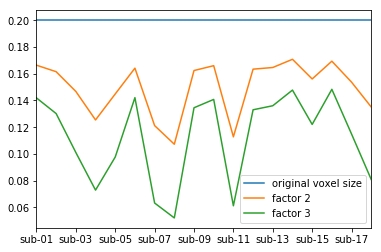

In [120]:
# Display the content of the DataFrame with a graph. 
non_nan_proportions.plot();

We can see that the proportion of non-NaN values in the rescaled images is very variable among our subjects. Still, **all of our subjects contain at least a reasonable proportion of non-NaN data**, taking into consideration that the number of voxels in our images is relatively high. 

### 5.3 Save the data

We will now save our **EEG dataset**, as well as our **preprocessed fMRI dataset**, for further use in the next Notebooks. The EEG dataset can be stored in a simple dictionary, and saved into a Pickle file. For the preprocessed fMRI dataset, which is much heavier and consists of NumPy arrays, it is better to use the NumPy .npz format. 

In [121]:
import pickle

In [122]:
# Create a dictionary to hold the data. 
predictors_EEG = dict()

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Define the path of the hypnogram and power spectrum, and extract the file as a Pandas DataFrame. 
    try:
        hypnogram_path = data_path + 'derivatives/' + subject_index + '_task-rest_hypnogram-powerspectrum.tsv'
        hypnogram = pd.read_csv(hypnogram_path, sep = '\t')
    except UnicodeDecodeError:
        hypnogram_path = repaired_files_path + '/' + subject_index + '_task-rest_hypnogram-powerspectrum.tsv'
        hypnogram = pd.read_csv(hypnogram_path, sep = '\t')
    
    # Store the result in the dictionary. 
    predictors_EEG[subject_index] = hypnogram

In [123]:
# Display the sizes of the different dictionaries. 
print(len(predictors_EEG))
print(len(predictors_fMRI))
print(len(predictors_fMRI_r2))
print(len(predictors_fMRI_r3))

18
18
18
18


In [124]:
# Save all the EEG predictors into a Pickle file. 
with open(preprocessed_data_path + 'predictors_EEG.p', 'wb') as file:
    pickle.dump(predictors_EEG, file)

In [125]:
# Save all the fMRI predictors into a .npz file. 
np.savez(preprocessed_data_path + 'predictors_fMRI.npz', 

         # fMRI predictors. 
         sub_1 = predictors_fMRI['sub-01'],
         sub_2 = predictors_fMRI['sub-02'],
         sub_3 = predictors_fMRI['sub-03'],
         sub_4 = predictors_fMRI['sub-04'],
         sub_5 = predictors_fMRI['sub-05'],
         sub_6 = predictors_fMRI['sub-06'],
         sub_7 = predictors_fMRI['sub-07'],
         sub_8 = predictors_fMRI['sub-08'],
         sub_9 = predictors_fMRI['sub-09'],
         sub_10 = predictors_fMRI['sub-10'],
         sub_11 = predictors_fMRI['sub-11'],
         sub_12 = predictors_fMRI['sub-12'],
         sub_13 = predictors_fMRI['sub-13'],
         sub_14 = predictors_fMRI['sub-14'],
         sub_15 = predictors_fMRI['sub-15'],
         sub_16 = predictors_fMRI['sub-16'],
         sub_17 = predictors_fMRI['sub-17'],
         sub_18 = predictors_fMRI['sub-18'])

In [126]:
# Save all the fMRI predictors, with a rescaled factor of 2, into a .npz file. 
np.savez(preprocessed_data_path + 'predictors_fMRI_r2.npz', 

         # fMRI predictors. 
         sub_1 = predictors_fMRI_r2['sub-01'],
         sub_2 = predictors_fMRI_r2['sub-02'],
         sub_3 = predictors_fMRI_r2['sub-03'],
         sub_4 = predictors_fMRI_r2['sub-04'],
         sub_5 = predictors_fMRI_r2['sub-05'],
         sub_6 = predictors_fMRI_r2['sub-06'],
         sub_7 = predictors_fMRI_r2['sub-07'],
         sub_8 = predictors_fMRI_r2['sub-08'],
         sub_9 = predictors_fMRI_r2['sub-09'],
         sub_10 = predictors_fMRI_r2['sub-10'],
         sub_11 = predictors_fMRI_r2['sub-11'],
         sub_12 = predictors_fMRI_r2['sub-12'],
         sub_13 = predictors_fMRI_r2['sub-13'],
         sub_14 = predictors_fMRI_r2['sub-14'],
         sub_15 = predictors_fMRI_r2['sub-15'],
         sub_16 = predictors_fMRI_r2['sub-16'],
         sub_17 = predictors_fMRI_r2['sub-17'],
         sub_18 = predictors_fMRI_r2['sub-18'])

In [127]:
# Save all the fMRI predictors, with a rescaled factor of 3, into a .npz file. 
np.savez(preprocessed_data_path + 'predictors_fMRI_r3.npz', 

         # fMRI predictors. 
         sub_1 = predictors_fMRI_r3['sub-01'],
         sub_2 = predictors_fMRI_r3['sub-02'],
         sub_3 = predictors_fMRI_r3['sub-03'],
         sub_4 = predictors_fMRI_r3['sub-04'],
         sub_5 = predictors_fMRI_r3['sub-05'],
         sub_6 = predictors_fMRI_r3['sub-06'],
         sub_7 = predictors_fMRI_r3['sub-07'],
         sub_8 = predictors_fMRI_r3['sub-08'],
         sub_9 = predictors_fMRI_r3['sub-09'],
         sub_10 = predictors_fMRI_r3['sub-10'],
         sub_11 = predictors_fMRI_r3['sub-11'],
         sub_12 = predictors_fMRI_r3['sub-12'],
         sub_13 = predictors_fMRI_r3['sub-13'],
         sub_14 = predictors_fMRI_r3['sub-14'],
         sub_15 = predictors_fMRI_r3['sub-15'],
         sub_16 = predictors_fMRI_r3['sub-16'],
         sub_17 = predictors_fMRI_r3['sub-17'],
         sub_18 = predictors_fMRI_r3['sub-18'])